라이브러리 설정 및 데이터 불러오기

In [1]:
# import pandas as pd
# import numpy as np

# import re

# import seaborn as sns
# import matplotlib.pyplot as plt

# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import LabelEncoder

# from sklearn.linear_model import LogisticRegression
# from sklearn.ensemble import RandomForestClassifier
# from xgboost import XGBClassifier

# from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

| 컬럼명(한글) | 컬럼명(영어) | 설명 | 분포(실제 분포) |
|---|---|---|---|
| 게임 ID | appid | Steam 게임 고유 ID | 440 ~ 3,241,660 (mean≈1,239,968) |
| 리뷰 추천 ID | recommendationid | 리뷰 고유 식별자 | 약 1.99e8 ~ 2.15e8 |
| 유저 Steam ID | steamid | 리뷰 작성자 Steam ID | 거의 단일값, 분산 매우 작음 |
| 보유 게임 수 | num_games_owned | 유저가 보유한 전체 게임 수 | 0 ~ 7,706 (median 0, mean 55.9) |
| 작성 리뷰 수 | num_reviews_author | 유저가 작성한 전체 리뷰 수 | 1 ~ 2,542 (median 3) |
| 누적 플레이 타임 | playtime_forever | 해당 게임 총 플레이 시간 | 5 ~ 1,457,369 |
| 최근 2주 플레이 타임 | playtime_last_two_weeks | 최근 2주간 플레이 시간 | 0 ~ 17,144 (75% ≤ 370) |
| 리뷰 시점 플레이 타임 | playtime_at_review | 리뷰 작성 시점 누적 플레이 시간 | 5 ~ 1,396,679 |
| Steam Deck 플레이 타임 | deck_playtime_at_review | 리뷰 시점 Steam Deck 플레이 시간 | 1 ~ 51,724 (표본 적음) |
| 마지막 플레이 시각 | last_played | 마지막 플레이 시점 (Unix) | 1.47e9 ~ 1.77e9 |
| 리뷰 생성 시각 | timestamp_created | 리뷰 최초 작성 시각 (Unix) | 1.75e9 ~ 1.77e9 |
| 리뷰 수정 시각 | timestamp_updated | 리뷰 최종 수정 시각 (Unix) | 생성 시각과 거의 동일 |
| 긍정 추천 여부 | voted_up | 긍정 리뷰 여부 (1=긍정) | mean 0.633 (긍정 약 63%) |
| 도움됨 투표 수 | votes_up | 도움이 됐다고 평가한 수 | 0 ~ 1,511 (대부분 0) |
| 재미있음 투표 수 | votes_funny | 재미있다고 평가한 수 | 0 ~ 438 (대부분 0) |
| 가중 투표 점수 | weighted_vote_score | Steam 내부 도움도 점수 | 0.29 ~ 0.95 (median 0.5) |
| 댓글 수 | comment_count | 리뷰에 달린 댓글 수 | 0 ~ 14 (99% 이상 0) |
| 개발자 응답 시각 | timestamp_dev_responded | 개발자 답변 시각 (Unix) | 존재 데이터 56건 |
| Steam 구매 여부 | steam_purchase | Steam에서 구매했는지 여부 | 없음 |
| 무료 획득 여부 | received_for_free | 무료로 받았는지 여부 | 없음 |
| 얼리액세스 작성 여부 | written_during_early_access | 얼리액세스 중 작성 여부 | 없음 |
| 리뷰 언어 | language | 리뷰 작성 언어 | 없음 |
| 리뷰 텍스트 | review | 리뷰 본문 텍스트 | 없음 |
| 개발자 응답 내용 | developer_response | 개발자 답변 텍스트 | 없음 |
| Steam Deck 주 사용 여부 | primarily_steam_deck | Steam Deck 위주 플레이 여부 | 없음 |
| 중복 appid | appid_1 | appid 중복 컬럼 | appid와 동일 |
| 난수 컬럼 | rnd | 무작위 샘플링용 컬럼 | 0 ~ 0.019 |

In [2]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from collections import Counter
from sklearn.metrics import confusion_matrix, classification_report
from xgboost import XGBClassifier
from joblib import Memory
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.base import clone
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, RandomizedSearchCV

import os
import xgboost as xgb
from tqdm.auto import tqdm
import joblib

plt.rc('font', family='Malgun Gothic')
plt.rc('axes', unicode_minus=False)

c:\Users\Playdata\SKN23-2ND-1TEAM\skn_venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
df = pd.read_csv('./data/steam_reviews_last365d.csv') # steam_reviews_last365d (1년치 데이터)
# df.head(3)

C:\Users\Playdata\AppData\Local\Temp\ipykernel_15964\2021230127.py:1: DtypeWarning: Columns (22) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('./data/steam_reviews_last365d.csv') # steam_reviews_last365d (1년치 데이터)


In [4]:
df.head(3)

,appid,recommendationid,steamid,num_games_owned,num_reviews_author,playtime_forever,playtime_last_two_weeks,playtime_at_review,deck_playtime_at_review,last_played,...,votes_up,votes_funny,weighted_vote_score,comment_count,steam_purchase,received_for_free,written_during_early_access,developer_response,timestamp_dev_responded,primarily_steam_deck
0,1049590,215264715,76561199653987525,0,1,393,0,393.0,NaN,1714156415,...,0,0,0.5,0,False,True,False,NaN,NaN,False
1,1049590,215253495,76561199088477441,0,2,110943,2336,110700.0,NaN,1767656186,...,0,0,0.5,0,False,False,False,NaN,NaN,False
2,1049590,215244780,76561199111467010,0,1,150415,3971,150415.0,NaN,1767541395,...,0,0,0.5,0,False,False,False,NaN,NaN,False


In [ ]:
df.shape

(5447573, 25)

In [5]:
# 상위 50개 게임 확인
# appid_counts = (df.groupby("appid").size().sort_values(ascending=False))
# appid_counts.head(50)

# 1. 데이터 로드 + 기본 탐색 (1차 EDA) + 파생변수 생성

- 상위 50개 게임으로만 이루어진 데이터 생성

In [5]:
# 상위 50개 게임으로만 이루어진 데이터
appid_counts = df['appid'].value_counts()
top50_appids = appid_counts.head(50).index.tolist()
df_top50 = df[df['appid'].isin(top50_appids)].copy()
# df_top50.head(3)

In [7]:
# 결측치 확인
df_top50.isnull().sum()

appid                                0
recommendationid                     0
steamid                              0
num_games_owned                      0
num_reviews_author                   0
playtime_forever                     0
playtime_last_two_weeks              0
playtime_at_review                   0
deck_playtime_at_review        4736661
last_played                          0
language                             0
review                           15761
timestamp_created                    0
timestamp_updated                    0
voted_up                             0
votes_up                             0
votes_funny                          0
weighted_vote_score                  0
comment_count                        0
steam_purchase                       0
received_for_free                    0
written_during_early_access          0
developer_response             4824716
timestamp_dev_responded        4824716
primarily_steam_deck                 0
dtype: int64

In [6]:
# 결측치 있는 컬럼들 모두 제거
df_model = df_top50.drop(columns=['deck_playtime_at_review', 'developer_response', 'timestamp_dev_responded'])
# df_model.dropna(subset=['review'], inplace=True)
df_model.isnull().sum()

appid                              0
recommendationid                   0
steamid                            0
num_games_owned                    0
num_reviews_author                 0
playtime_forever                   0
playtime_last_two_weeks            0
playtime_at_review                 0
last_played                        0
language                           0
review                         15761
timestamp_created                  0
timestamp_updated                  0
voted_up                           0
votes_up                           0
votes_funny                        0
weighted_vote_score                0
comment_count                      0
steam_purchase                     0
received_for_free                  0
written_during_early_access        0
primarily_steam_deck               0
dtype: int64

In [9]:
df_model.shape

(4830884, 22)

In [76]:
df_model.head(3)

,appid,recommendationid,steamid,num_games_owned,num_reviews_author,playtime_forever,playtime_last_two_weeks,playtime_at_review,last_played,review,...,language_german,language_koreana,language_other,language_polish,language_russian,language_schinese,language_spanish,language_turkish,game_style_story,game_style_video
27798,2139460,215256415,76561198092089560,0,1,1659,1659,1628.0,1767647101,"Un juego bastante completo, con diferentes esc...",...,0,0,0,0,0,0,0,0,0,0
27799,2139460,215256182,76561197995642012,0,4,370,367,339.0,1767646994,En découverte encore mais pour l'instant super...,...,0,0,0,0,0,0,0,0,0,0
27800,2139460,215249671,76561198217416651,0,32,552,552,401.0,1767648127,very nice game solo or play with team,...,0,0,1,0,0,0,0,0,0,0


## game_stlye 매핑

- 상위 50개 기반으로 appid, game_style 매핑
    - online (지속 접속형 / 서비스형 게임) 멀티플레이성 / 플레이 패턴이 짧고 빈번   
    - story (엔딩 소비형 / 완결형 게임) 스토리 엔딩 / 플레이 기간 짧고 집중적 / 엔딩 후 접속 없는게 정상  
    - video (지속 싱글/샌드박스형) 싱글플레이 중심 / 엔딩이후에도 콘텐츠 존재

In [24]:
# Top50 기반으로 appid, game_style 매핑

STYLE_MAP = {
    3241660: "online",  # R.E.P.O
    2807960: "online",  # Battlefield™ 6
    730:     "online",  # Counter-Strike 2
    1808500: "online",  # ARC Raiders
    1030300: "story",   # Hollow Knight: Silksong
    570:     "online",  # Dota 2
    578080:  "online",  # PUBG
    2246340: "video",   # Monster Hunter Wilds
    2592160: "story",   # Dispatch
    553850:  "online",  # HELLDIVERS™ 2
    3240220: "online",  # Grand Theft Auto V Enhanced
    1091500: "story",   # Cyberpunk 2077
    1903340: "video",   # Clair Obscur: Expedition 33
    2001120: "story",   # Split Fiction
    1245620: "video",   # Elden Ring
    1086940: "video",   # Baldur's Gate 3
    1144200: "online",  # Ready or Not
    3167020: "video",   # Escape From Duckov
    3564740: "online",  # Where Winds Meet
    227300:  "video",   # Euro Truck Simulator 2
    108600:  "video",   # Project Zomboid
    413150:  "video",   # Stardew Valley
    1771300: "video",   # Kingdom Come 2
    3489700: "story",   # Stellar Blade™
    1172470: "online",  # Apex
    1222140: "story",   # Detroit: Become Human
    1326470: "video",   # Sons Of The Forest
    990080:  "story",   # Hogwarts Legacy
    1551360: "video",   # Forza Horizon 5
    1623730: "video",   # Palworld
    1145350: "video",   # Hades II
    2183900: "story",   # Space Marine AE
    230410:  "online",  # Warframe
    2139460: "online",  # Once Human
    236390:  "online",  # War Thunder
    440:     "online",  # Team Fortress 2
    1973530: "online",  # Limbus Company
    394360:  "video",   # Hearts of Iron IV
    3932890: "online",  # Escape from Tarkov
    526870:  "video",   # Satisfactory
    3513350: "online",  # Wuthering Waves
    3405690: "online",  # EA SPORTS FC™ 26
    2622380: "video",   # ELDEN RING NIGHTREIGN
    814380:  "video",   # Sekiro™: Shadows Die Twice - GOTY Edition
    648800:  "video",   # Raft
    3159330: "story",   # Assassin’s Creed Shadows
    3527290: "video",   # PEAK
    2651280: "story",   # Spider-Man 2
    294100:  "video",   # RimWorld
    1222670: "video",   # The Sims 4
}

# game_style 컬럼 생성
df_model["game_style"] = df_model["appid"].map(STYLE_MAP)
df_model["game_style"].value_counts()

game_style
online    2458928
video     1421636
story      932657
Name: count, dtype: int64

C:\Users\Playdata\AppData\Local\Temp\ipykernel_15964\1175175622.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


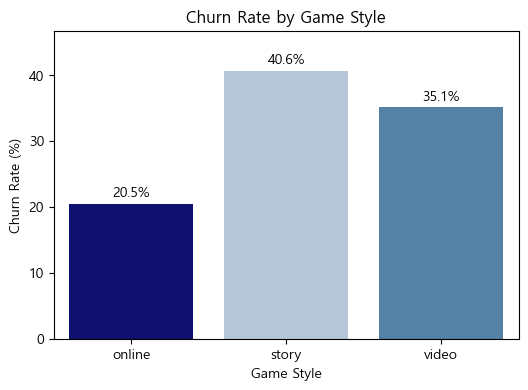

In [28]:
style_churn = (
    df_model.groupby('game_style')['churn']
            .mean()
            .mul(100)
            .reset_index()
)

plt.figure(figsize=(6,4))

ax = sns.barplot(
    data=style_churn,
    x='game_style',
    y='churn',
    palette=["navy", "lightsteelblue", "steelblue"]  # 3색
)

plt.ylabel("Churn Rate (%)")
plt.xlabel("Game Style")
plt.title("Churn Rate by Game Style")

# 바 위에 퍼센트 라벨 추가
for container in ax.containers:
    ax.bar_label(
        container,
        fmt="%.1f%%",
        padding=3,
        fontsize=10
    )

plt.ylim(0, style_churn['churn'].max() * 1.15)  # 라벨 잘리기 방지
plt.show()


## 'review' 결측 및 공백 행 제거

- review 결측 appid별 분포 확인 구문

In [8]:
# appid별 review 결측치 분포
review_na_by_app = (
    df_model.groupby("appid")["review"]
      .apply(lambda s: s.isna().sum())
      .rename("review_na_cnt")
      .to_frame()
)

# appid별 전체 행 수
total_by_app = df_model.groupby("appid").size().rename("total_cnt").to_frame()

# 합치기 + 비율
review_na_stats = (
    total_by_app.join(review_na_by_app, how="left")
                .fillna({"review_na_cnt": 0})
)

review_na_stats["review_na_ratio"] = review_na_stats["review_na_cnt"] / review_na_stats["total_cnt"]

# 결측치 많은 순으로 확인
review_na_stats.sort_values("review_na_cnt", ascending=False).head(30)

,total_cnt,review_na_cnt,review_na_ratio
appid,,,
3241660,341851,1067,0.003121
2807960,301260,1051,0.003489
1808500,253341,991,0.003912
3240220,139431,675,0.004841
730,273327,668,0.002444
1091500,120404,566,0.004701
553850,148578,510,0.003433
578080,194464,500,0.002571
1030300,239171,493,0.002061


- churn 라벨 생성 전 review가 NaN인 행 드롭

In [9]:
# review NaN 드롭
before = len(df_model)
df_model = df_model[df_model["review"].notna()].copy()
after = len(df_model)

print(f"[drop NaN review] before={before:,} -> after={after:,} (dropped {before-after:,})")

[drop NaN review] before=4,830,884 -> after=4,815,123 (dropped 15,761)


- appid별 공백/빈 문자열 리뷰 개수 확인 구문

In [10]:
# 공백/빈문자열(whitespace-only 포함) 마스크
blank_mask = df_model["review"].astype(str).str.strip().eq("")

blank_by_appid = (
    df_model.assign(is_blank_review=blank_mask)
            .groupby("appid")["is_blank_review"]
            .agg(total_cnt="size", blank_cnt="sum")
)

blank_by_appid["blank_ratio"] = blank_by_appid["blank_cnt"] / blank_by_appid["total_cnt"]

# 공백 리뷰가 있는 appid만, blank_cnt 큰 순으로 보기
blank_by_appid_nonzero = blank_by_appid[blank_by_appid["blank_cnt"] > 0].sort_values("blank_cnt", ascending=False)

display(blank_by_appid_nonzero.head(50))
print("공백 리뷰 총 개수:", int(blank_mask.sum()))

,total_cnt,blank_cnt,blank_ratio
appid,,,
730,272659,186,0.000682
3241660,340784,159,0.000467
3240220,138756,130,0.000937
2807960,300209,121,0.000403
578080,193964,111,0.000572
570,204123,94,0.000461
227300,92225,74,0.000802
1808500,252350,73,0.000289
1030300,238678,59,0.000247


공백 리뷰 총 개수: 1902


- 공백/빈 문자열 리뷰 드롭

In [11]:
# 공백/빈 문자열 리뷰 드롭
before = len(df_model)

blank_mask = df_model["review"].astype(str).str.strip().eq("")
df_model = df_model[~blank_mask].copy()

after = len(df_model)
print(f"[drop blank review] before={before:,} -> after={after:,} (dropped {before-after:,})")

[drop blank review] before=4,815,123 -> after=4,813,221 (dropped 1,902)


## 'game_style' 별, 타겟 변수 'churn' 생성

- churn 라벨 생성 (style별 기준일 적용) 목적으로

In [12]:
# style별 churn 기준일(일 단위)
STYLE_WINDOW_DAYS = {
    "online": 7,
    "video": 10,
    "story": 5,
}

# 리뷰 시각 / 마지막 플레이 시각
review_dt = pd.to_datetime(df_model["timestamp_created"], unit="s", errors="coerce")
last_dt   = pd.to_datetime(df_model["last_played"], unit="s", errors="coerce")

# 리뷰 이후 며칠 뒤에 마지막 플레이가 있었는지
df_model["days_after_review"] = (last_dt - review_dt).dt.days

# game_style별 기준일 매핑
df_model["churn_window_days"] = df_model["game_style"].map(STYLE_WINDOW_DAYS)

# 기본 churn: days_after_review < window 이면 churn=1 (떠난 것)
df_model["churn"] = (df_model["days_after_review"] < df_model["churn_window_days"]).astype(int)

# 예외 처리
df_model.loc[df_model["last_played"] == 0, "churn"] = 1
df_model.loc[df_model["days_after_review"] < 0, "churn"] = 1

print(df_model["churn"].value_counts().sort_index())

churn
0    3432753
1    1380468
Name: count, dtype: int64


- churn 전체 비율 확인 (불균형 확인)

In [13]:
df_model['churn'].value_counts(normalize=True)  # 7:3 정상

churn
0    0.713192
1    0.286808
Name: proportion, dtype: float64

#### 'good review' 칼럼 생성

In [14]:
# 1) 언어별 키워드 사전
# - phrases: 문장/구문(부분일치 OK)
# - words: 단어성 키워드(라틴권은 단어경계 \b 적용)
# - neg: 부정 구문(걸리면 good=0으로 처리)
# - boundary: words에 \b를 붙일지 여부 (중국어/일본어/태국어/한국어는 보통 False)
LEXICON = {
    # English
    "english": {
        "phrases": [
            r"highly recommend(?:ed)?",
            r"definitely recommend",
            r"worth (?:buying|it|the money|the time)",
            r"great game",
            r"amazing game",
            r"awesome game",
            r"best game(?:s)?",
        ],
        "words": [
            r"awesome", r"amazing", r"great", r"excellent", r"fantastic", r"incredible",
            r"masterpiece", r"perfect", r"love", r"fun", r"enjoy", r"recommend", r"worth",
        ],
        "neg": [
            r"not\s+good", r"not\s+great", r"not\s+worth",
            r"(?:do\s*not|don't|dont)\s+recommend",
            r"(?:do\s*not|don't|dont)\s+buy",
            r"can't\s+recommend|cant\s+recommend",
            r"avoid\b", r"refund\b",
        ],
        "boundary": True,
    },

    # Spanish (Spain) + LatAm는 같이 처리
    "spanish": {
        "phrases": [r"muy bueno", r"vale la pena", r"lo recomiendo", r"recomendad[oa]"],
        "words": [r"genial", r"excelente", r"buen[oa]", r"incre[ií]ble", r"recomiendo", r"recomendar"],
        "neg": [r"no\s+recomiendo", r"no\s+vale\s+la\s+pena", r"no\s+es\s+buen[oa]", r"no\s+merece\s+la\s+pena", r"no\s+compr(?:es|ar)"],
        "boundary": True,
    },
    "latam": {  # 라틴아메리카 스페인어
        "phrases": [r"muy bueno", r"vale la pena", r"lo recomiendo", r"recomendad[oa]"],
        "words": [r"genial", r"excelente", r"buen[oa]", r"incre[ií]ble", r"recomiendo", r"recomendar"],
        "neg": [r"no\s+recomiendo", r"no\s+vale\s+la\s+pena", r"no\s+es\s+buen[oa]", r"no\s+merece\s+la\s+pena", r"no\s+compr(?:es|ar)"],
        "boundary": True,
    },

    # Portuguese (PT / BR)
    "portuguese": {
        "phrases": [r"vale a pena", r"recomendo", r"muito bom", r"jogo (?:muito )?bom"],
        "words": [r"ótimo", r"excelente", r"incr[ií]vel", r"perfeito", r"divertido", r"recomendar"],
        "neg": [r"não\s+recomendo", r"nao\s+recomendo", r"não\s+vale\s+a\s+pena", r"nao\s+vale\s+a\s+pena", r"não\s+é\s+bom", r"nao\s+e\s+bom", r"não\s+compr(?:e|ar)", r"nao\s+compr(?:e|ar)"],
        "boundary": True,
    },
    "brazilian": {  # 브라질 포르투갈어
        "phrases": [r"vale a pena", r"recomendo", r"muito bom", r"jogo (?:muito )?bom"],
        "words": [r"ótimo", r"excelente", r"incr[ií]vel", r"perfeito", r"divertido", r"recomendar"],
        "neg": [r"não\s+recomendo", r"nao\s+recomendo", r"não\s+vale\s+a\s+pena", r"nao\s+vale\s+a\s+pena", r"não\s+é\s+bom", r"nao\s+e\s+bom", r"não\s+compr(?:e|ar)", r"nao\s+compr(?:e|ar)"],
        "boundary": True,
    },

    # German
    "german": {
        "phrases": [r"sehr gut", r"klare(?:s)? empfehlung", r"lohnt sich", r"absolut empfehl"],
        "words": [r"genial", r"toll", r"super", r"großartig", r"exzellent", r"empfehle", r"empfehlenswert"],
        "neg": [r"nicht\s+empfehl", r"lohnt\s+sich\s+nicht", r"nicht\s+gut", r"kau(?:f|ft)\s+nicht", r"kein\s+kauf"],
        "boundary": True,
    },

    # French
    "french": {
        "phrases": [r"je recommande", r"vaut le coup", r"tr[eè]s bon", r"excellent jeu"],
        "words": [r"g[eé]nial", r"excellent", r"super", r"incroyable", r"parfait", r"recommande"],
        "neg": [r"je\s+ne\s+recommande\s+pas", r"ne\s+vaut\s+pas\s+le\s+coup", r"pas\s+bon", r"n['’]achetez\s+pas", r"n['’]ach[eè]te\s+pas"],
        "boundary": True,
    },

    # Italian
    "italian": {
        "phrases": [r"lo consiglio", r"vale la pena", r"molto bello", r"gioco (?:molto )?bello"],
        "words": [r"fantastico", r"ottimo", r"eccellente", r"stupendo", r"divertente", r"consiglio", r"consigliare"],
        "neg": [r"non\s+lo\s+consiglio", r"non\s+vale\s+la\s+pena", r"non\s+[eè]\s+bello", r"non\s+compr(?:are|atelo)"],
        "boundary": True,
    },

    # Dutch
    "dutch": {
        "phrases": [r"zeker aanraden", r"de moeite waard", r"heel goed", r"geweldig spel"],
        "words": [r"geweldig", r"fantastisch", r"super", r"leuk", r"aanraden", r"aanbevelen", r"waarde"],
        "neg": [r"niet\s+aanrad", r"niet\s+de\s+moeite\s+waard", r"niet\s+goed", r"koop\s+niet"],
        "boundary": True,
    },

    # Swedish / Norwegian / Danish / Finnish
    "swedish": {
        "phrases": [r"rekommenderar", r"värt det", r"jättebra", r"riktigt bra"],
        "words": [r"fantastisk", r"grym", r"suverän", r"toppen", r"kul", r"rekommendera", r"värd"],
        "neg": [r"rekommenderar\s+inte", r"inte\s+värt", r"inte\s+bra", r"köp\s+inte"],
        "boundary": True,
    },
    "norwegian": {
        "phrases": [r"anbefaler", r"verdt det", r"kjempebra", r"veldig bra"],
        "words": [r"fantastisk", r"råbra", r"suveren", r"gøy", r"anbefale", r"verdt"],
        "neg": [r"anbefaler\s+ikke", r"ikke\s+verdt", r"ikke\s+bra", r"ikke\s+kjøp"],
        "boundary": True,
    },
    "danish": {
        "phrases": [r"anbefaler", r"v[æa]rd at", r"mega god", r"rigtig god"],
        "words": [r"fantastisk", r"fremragende", r"super", r"sjov", r"anbefale", r"v[æa]rd"],
        "neg": [r"anbefaler\s+ikke", r"ikke\s+v[æa]rd", r"ikke\s+god", r"k[oø]b\s+ikke"],
        "boundary": True,
    },
    "finnish": {
        "phrases": [r"suosittelen", r"todella hyv[äa]", r"sen arvoinen", r"hyv[äa] peli"],
        "words": [r"loistava", r"mahtava", r"erinomainen", r"hauska", r"suositella", r"arvoinen"],
        "neg": [r"en\s+suosittele", r"ei\s+kannata", r"ei\s+hyv[äa]", r"älä\s+osta"],
        "boundary": True,
    },

    # Polish / Czech / Romanian / Hungarian / Bulgarian / Greek / Ukrainian / Russian / Turkish
    "polish": {
        "phrases": [r"polecam", r"warto", r"świetna gra", r"bardzo dobra"],
        "words": [r"świetn[aey]", r"super", r"rewelacyjna", r"doskonała", r"polecić", r"warto"],
        "neg": [r"nie\s+polecam", r"nie\s+warto", r"nie\s+jest\s+dobr", r"nie\s+kupuj"],
        "boundary": True,
    },
    "czech": {
        "phrases": [r"doporu[čc]uji", r"stoj[ií]\s+za\s+to", r"skv[ěe]l[aá]", r"v[ýy]born[aá]"],
        "words": [r"super", r"skv[ěe]l", r"v[ýy]born", r"bav[ií]", r"doporu[čc]it"],
        "neg": [r"nedoporu[čc]uji", r"nestoj[ií]\s+za\s+to", r"nen[ií]\s+dobr", r"nekupuj"],
        "boundary": True,
    },
    "romanian": {
        "phrases": [r"recomand", r"merit[ăa]", r"foarte bun", r"joc (?:foarte )?bun"],
        "words": [r"excelent", r"minunat", r"super", r"recomanda", r"merit"],
        "neg": [r"nu\s+recomand", r"nu\s+merit[ăa]", r"nu\s+e\s+bun", r"nu\s+cump[ăa]ra"],
        "boundary": True,
    },
    "hungarian": {
        "phrases": [r"aj[aá]nlom", r"meg[eé]ri", r"nagyon j[oó]", r"szuper j[aá]t[eé]k"],
        "words": [r"szuper", r"fantasztikus", r"kiv[aá]l[oó]", r"nagyon", r"aj[aá]nlani", r"meg[eé]r"],
        "neg": [r"nem\s+aj[aá]nlom", r"nem\s+[eé]ri\s+meg", r"nem\s+j[oó]", r"ne\s+vedd\s+meg"],
        "boundary": True,
    },
    "bulgarian": {
        "phrases": [r"препоръч", r"много добра", r"страхотна", r"заслужава си"],
        "words": [r"страхот", r"отлич", r"супер", r"препоръч", r"шедьовър"],
        "neg": [r"не\s+препоръч", r"не\s+си\s+струва", r"не\s+е\s+доб", r"не\s+купувай"],
        "boundary": False,  # кир릴은 \b가 애매해서 단순부분일치로
    },
    "greek": {
        "phrases": [r"το\s+προτείν", r"αξίζει", r"πολύ\s+καλ", r"εξαιρετικ"],
        "words": [r"τέλει", r"φοβε", r"εξαιρετικ", r"καταπληκτικ", r"προτείν", r"αξίζ"],
        "neg": [r"δεν\s+προτείν", r"δεν\s+αξίζ", r"δεν\s+είναι\s+καλ", r"μην\s+αγοράσ"],
        "boundary": False,
    },
    "ukrainian": {
        "phrases": [r"рекоменд", r"дуже\s+хорош", r"варто", r"чудов"],
        "words": [r"відмін", r"класн", r"шедевр", r"рекоменд", r"варто"],
        "neg": [r"не\s+рекоменд", r"не\s+варто", r"не\s+хорош", r"не\s+купуй"],
        "boundary": False,
    },
    "russian": {
        "phrases": [r"рекоменд", r"очень\s+хорош", r"стоит", r"шедевр"],
        "words": [r"отлич", r"классн", r"супер", r"шедевр", r"рекоменд", r"стоит"],
        "neg": [r"не\s+рекоменд", r"не\s+стоит", r"плох", r"не\s+покупай", r"не\s+берите"],
        "boundary": False,
    },
    "turkish": {
        "phrases": [r"kesinlikle tavsiye", r"tavsiye ederim", r"çok iyi", r"mükemmel", r"harika"],
        "words": [r"güzel", r"mükemmel", r"harika", r"şahane", r"tavsiye", r"değer"],
        "neg": [r"tavsiye etmem", r"tavsiye etmiyorum", r"iyi değil", r"alma", r"almayın", r"değmez"],
        "boundary": True,
    },

    # Korean / Japanese / Chinese / Arabic / Thai / Vietnamese / Indonesian
    "koreana": {
        "phrases": [r"강추", r"완전 추천", r"강력 추천", r"갓겜", r"명작", r"존잼", r"개꿀잼", r"재밌", r"재미있"],
        "words": [r"추천", r"최고", r"꿀잼", r"재미", r"좋다", r"훌륭", r"완벽", r"감동"],
        "neg": [r"비추", r"추천\s*안", r"추천\s*하지", r"재미없", r"별로", r"최악", r"사지\s*마", r"사지마", r"환불"],
        "boundary": False,
    },
    "japanese": {
        "phrases": [r"おすすめ", r"オススメ", r"最高", r"神ゲー", r"買う価値", r"面白い", r"楽しい"],
        "words": [r"おすすめ", r"最高", r"神", r"面白", r"楽しい", r"良い", r"素晴らしい"],
        "neg": [r"おすすめしない", r"買わない方が", r"つまらない", r"面白くない", r"最悪", r"返品"],
        "boundary": False,
    },
    "schinese": {
        "phrases": [r"强烈推荐", r"非常推荐", r"值得买", r"值得入", r"很值得", r"很好玩", r"神作", r"精品"],
        "words": [r"推荐", r"值得", r"好玩", r"很好", r"优秀", r"完美", r"喜欢"],
        "neg": [r"不推荐", r"不值得", r"不好玩", r"垃圾", r"别买", r"千万别买", r"退款"],
        "boundary": False,
    },
    "tchinese": {
        "phrases": [r"強烈推薦", r"非常推薦", r"值得買", r"值得入", r"很值得", r"很好玩", r"神作", r"精品"],
        "words": [r"推薦", r"值得", r"好玩", r"很好", r"優秀", r"完美", r"喜歡"],
        "neg": [r"不推薦", r"不值得", r"不好玩", r"垃圾", r"別買", r"千萬別買", r"退款"],
        "boundary": False,
    },
    "arabic": {
        "phrases": [r"أنصح", r"ممتاز", r"رائع", r"يستحق", r"لعبة رائعة", r"ممتعة"],
        "words": [r"ممتاز", r"رائع", r"جميل", r"ممتع", r"يستحق", r"أنصح"],
        "neg": [r"لا\s+أنصح", r"لا\s+يستحق", r"سيئ", r"لا\s+تشتري", r"استرجاع"],
        "boundary": False,
    },
    "thai": {
        "phrases": [r"แนะนำ", r"ดีมาก", r"สุดยอด", r"คุ้มค่า", r"สนุกมาก", r"โคตรสนุก"],
        "words": [r"แนะนำ", r"ดี", r"สนุก", r"สุดยอด", r"คุ้ม", r"ชอบ"],
        "neg": [r"ไม่แนะนำ", r"ไม่คุ้ม", r"ไม่ดี", r"แย่", r"อย่าซื้อ", r"ขอคืนเงิน"],
        "boundary": False,
    },
    "vietnamese": {
        "phrases": [r"rất hay", r"tuyệt vời", r"đáng mua", r"đáng tiền", r"nên mua", r"khuyên dùng"],
        "words": [r"hay", r"tuyệt", r"xuất sắc", r"đáng", r"thích", r"khuyên", r"nên"],
        "neg": [r"không\s+khuyên", r"không\s+đáng", r"đừng\s+mua", r"tệ", r"chán", r"hoàn tiền"],
        "boundary": True,
    },
    "indonesian": {
        "phrases": [r"sangat bagus", r"rekomendasi", r"worth it", r"layak dibeli", r"seru banget"],
        "words": [r"bagus", r"keren", r"mantap", r"seru", r"rekomend", r"layak"],
        "neg": [r"tidak\s+rekomend", r"jangan\s+beli", r"tidak\s+layak", r"jelek", r"buruk", r"refund"],
        "boundary": True,
    },
}

# 없는 언어는 english로 fallback
DEFAULT_LANG = "english"


# 2) 정규식 빌더
def _compile_lexicon(cfg):
    boundary = cfg.get("boundary", True)

    parts_good = []
    for p in cfg.get("phrases", []):
        parts_good.append(f"(?:{p})")
    for w in cfg.get("words", []):
        if boundary:
            parts_good.append(rf"\b{w}\b")
        else:
            parts_good.append(f"(?:{w})")

    good_pat = "|".join(parts_good) if parts_good else r"$^"
    good_re = re.compile(good_pat, flags=re.UNICODE)

    neg_parts = [f"(?:{p})" for p in cfg.get("neg", [])]
    neg_pat = "|".join(neg_parts) if neg_parts else r"$^"
    neg_re = re.compile(neg_pat, flags=re.UNICODE)

    return good_re, neg_re


_COMPILED = {}
for lang, cfg in LEXICON.items():
    _COMPILED[lang] = _compile_lexicon(cfg)
_COMPILED[DEFAULT_LANG] = _COMPILED.get(DEFAULT_LANG, _compile_lexicon(LEXICON["english"]))


def add_good_flag_multilang(df_model, text_col="review", lang_col="language"):
    out = df_model.copy()

    text = out[text_col].fillna("").astype(str).str.casefold()
    lang = out[lang_col].fillna(DEFAULT_LANG).astype(str)

    good_hit = pd.Series(False, index=out.index)
    neg_hit  = pd.Series(False, index=out.index)

    for l in lang.unique():
        mask = (lang == l)
        good_re, neg_re = _COMPILED.get(l, _COMPILED[DEFAULT_LANG])

        good_hit.loc[mask] = text.loc[mask].str.contains(good_re, regex=True)
        neg_hit.loc[mask]  = text.loc[mask].str.contains(neg_re,  regex=True)

    out["good_review"] = (good_hit & (~neg_hit)).astype(int)
    return out


# df_good = add_good_flag_multilang(df, text_col="review", lang_col="language")
# print(df_good["good_review"].value_counts())
df_model = add_good_flag_multilang(df_model, text_col="review", lang_col="language")
print(df_model["good_review"].value_counts())

# 1m 30s

good_review
0    3525940
1    1287281
Name: count, dtype: int64


- playtime 분포 확인 (원본, 로그)

In [18]:
# plt.figure(figsize=(6,4))
# plt.hist(df['playtime_at_review'], bins=100)
# plt.title('Playtime at Review (Raw)')
# plt.show()
# # 대부분 왼쪽에 몰려 있으면 로그 확정

In [19]:
# df_model['log_playtime'] = np.log1p(df_model['playtime_at_review'])

# plt.figure(figsize=(6,4))
# plt.hist(df_model['log_playtime'], bins=100)
# plt.title('Log Playtime at Review')
# plt.show()
# # playtime_stage 구간 나눔 근거 확보

## 파생 변수 추가

변수 추가하는 이유  
=> X feature가 “상태 설명”만 하고 “행동 패턴”을 설명하지 못함 (성능 정체)  

churn 예측 성능을 올리려면 “값”이 아니라  
“관계·비율·행동 패턴”을 feature로 만들어야 한다.  

In [20]:
# df_model['playtime_at_review'].max()  # 2789459.0
# df_model['num_games_owned'].max()   # 38168
# df_model['votes_up'].max()  # 20098
# df_model['votes_funny'].max()  # 6372
# df_model['comment_count'].max()  # 4500
# df_model['num_reviews_author'].max()  # 19748

In [15]:
### 추가한 파생변수..

# 1. 리뷰 시점 플레이 집중도 (플레이타임 “규모” → “강도 / 몰입도”로 바꾸기)
# 게임 많이 가진데 이 게임만 오래 함 → 비이탈 / 게임 많고 얕게만 함 → 이탈 가능성↑
df_model['playtime_per_game'] = np.log1p(df_model['playtime_at_review'] / (df_model['num_games_owned'] + 1))


# 2. 리뷰 작성 시점의 몰입 단계 => churn과 매우 잘 갈림 (충성도?)

# log 변환
df_model['log_playtime'] = np.log1p(df_model['playtime_at_review'])
# 구간 나누기
bins = [-np.inf, 4, 8, np.inf]
labels = ['short', 'mid', 'long']

df_model['playtime_stage'] = pd.cut(
    df_model['log_playtime'],
    bins=bins,
    labels=labels
)
# 원하는 이름으로 0/1 컬럼 만들기
df_model['is_short_play'] = (df_model['playtime_stage'] == 'short').astype(int)
df_model['is_mid_play']   = (df_model['playtime_stage'] == 'mid').astype(int)
df_model['is_long_play']  = (df_model['playtime_stage'] == 'long').astype(int)



# *** 유저 성향 피처 (엄청 중요!)
# 3. 리뷰어 성향 (리뷰 중독자 vs 일반 유저)
# 리뷰를 많이 쓰는 사람 → 서비스 잔존율 높음 / 리뷰 거의 안 쓰는 사람 → 이탈 가능성↑ (충성도?)
df_model['reviews_per_game'] = np.log1p(df_model['num_reviews_author'] / (df_model['num_games_owned'] + 1))



# 4. “경험 많은/적은 유저” 여부
df_model['log_num_games_owned'] = np.log1p(df_model['num_games_owned'])
df_model['log_num_reviews_author'] = np.log1p(df_model['num_reviews_author'])

# 헤비 유저
df_model['is_heavy_user'] = (
    (df_model['log_num_games_owned'] > 5.0) & 
    (df_model['log_num_reviews_author'] > 3.5)
).astype(int)
# 라이트 유저 (헤비보다 더 중요한 컬럼.)
df_model['is_light_user'] = (
    (df_model['log_num_games_owned'] < 2.0) &
    (df_model['log_num_reviews_author'] < 1.0)
).astype(int)




# 5. 리뷰 감정 × 행동 결합 피처 (***핵심!!!)
# 5-1. 긍정 리뷰 + 낮은 플레이타임 = 위험
df_model['positive_but_short_play'] = (
    (df_model['good_review'] == 1) & 
    (df_model['playtime_at_review'] < 60)
).astype(int)
# “좋다고는 했는데 금방 떠난 사람” → churn에 엄청 강함

# 5-2. 부정 리뷰 + 높은 플레이타임
df_model['negative_but_long_play'] = (
    (df_model['good_review'] == 0) & 
    (df_model['playtime_at_review'] > 1200)
).astype(int)
# -> 욕하면서 계속 하는 타입 = 비이탈



# 6. 사회적 반응 파생 피처 (반응 여부 자체)
df_model['has_votes'] = ((df_model['votes_up'] + df_model['votes_funny']) > 0).astype(int)
df_model['has_comment'] = (df_model['comment_count'] > 0).astype(int)



# +
# 7. 리뷰 업데이트의 진정성 (Review Freshness) (아주 좋다고 합니다!!)
# timestamp_created와 timestamp_updated가 다른 유저는 게임에 아주 깊게 관여하고 있는 유저이다.
# 리뷰를 수정했다는 것은 이탈하지 않고 게임을 지속하며 의견을 업데이트했다는 강력한 증거.
# (비이탈 그룹에서 높게 나타날 확률이 큼)
# # 리뷰 수정 여부 (관여도)
df_model['is_updated_review'] = (df_model['timestamp_created'] != df_model['timestamp_updated']).astype(int)

# +
# 8. 커뮤니티 신뢰도 밀도 (Social Density)
# votes_up이나 comment_count는 데이터가 매우 희소(sparse).
# 이를 개별로 두지 않고, 유저의 '활동량' 대비 얼마나 많은 반응을 끌어냈는지 비율로 전환하면 모델이 학습하기 훨씬 수월해진다.
# 평소 리뷰를 100개 쓰는 사람이 추천 1개 받는 것보다, 리뷰를 1개 썼는데 추천 1개를 받는 것이 훨씬 '핵심 유저'일 가능성이 높다.
# 영향력 있는 리뷰어는 커뮤니티 활동 때문에라도 이탈률이 낮게 측정되는 경우가 많다.
# # 리뷰 1개당 평균 반응도 (커뮤니티 영향력)
df_model['social_density'] = np.log1p((df_model['votes_up'] + df_model['comment_count']) / (df_model['num_reviews_author'] + 1))
# 이거는 'has_votes', 'has_comment' 조금 겹칠 수 도 있는데 굳이 안빼도 된다고 합니다.
# 제거할 거면 모델 학습 완료하고, feature importance / coefficient 확인 헤서 위 두개와 비교 후에 제거 하는게 좋다고 합니다!


# 안전 처리 (inf, -inf 제거)
df_model.replace([np.inf, -np.inf], 0, inplace=True)

df_model.head(3)

# 파생변수 재료 컬럼
# df_model['playtime_at_review','num_games_owned','log_playtime','playtime_stage', 'num_reviews_author',
#         'log_num_games_owned','log_num_reviews_author', 'good_review', 'votes_up', 'votes_funny', 'comment_count',
#         'timestamp_created','timestamp_updated'] 

# 파생변수 컬럼
# df_model[['playtime_per_game','is_short_play','is_mid_play','is_long_play','reviews_per_game'
#         , 'is_heavy_user', 'is_light_user', 'positive_but_short_play', 'negative_but_long_play'
#         , 'has_votes', 'has_comment', 'is_updated_review', 'social_density']]

,appid,recommendationid,steamid,num_games_owned,num_reviews_author,playtime_forever,playtime_last_two_weeks,playtime_at_review,last_played,language,...,log_num_games_owned,log_num_reviews_author,is_heavy_user,is_light_user,positive_but_short_play,negative_but_long_play,has_votes,has_comment,is_updated_review,social_density
27798,2139460,215256415,76561198092089560,0,1,1659,1659,1628.0,1767647101,english,...,0.0,0.693147,0,1,0,1,0,0,0,0.0
27799,2139460,215256182,76561197995642012,0,4,370,367,339.0,1767646994,french,...,0.0,1.609438,0,0,0,0,0,0,0,0.0
27800,2139460,215249671,76561198217416651,0,32,552,552,401.0,1767648127,greek,...,0.0,3.496508,0,0,0,0,0,0,0,0.0


# 2. EDA 및 그래프 시각화 (2차)

C:\Users\Playdata\AppData\Local\Temp\ipykernel_21400\1383955768.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(


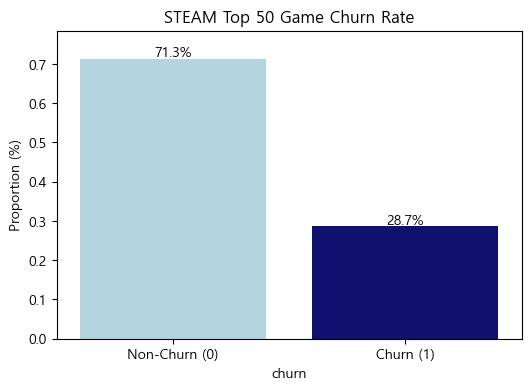

In [22]:
# 타겟 분포
churn_counts = df_model['churn'].value_counts(normalize=True)
# print("Churn Distribution (0=Non-Churn, 1=Churn):")
# print(churn_counts)

# 시각화
plt.figure(figsize=(6,4))
bars = sns.barplot(
    x=churn_counts.index, 
    y=churn_counts.values, 
    palette=["lightblue", "navy"]  # 0=light, 1=dark
)

# title과 axis labels
plt.xticks([0,1], ['Non-Churn (0)', 'Churn (1)'])
plt.ylabel("Proportion (%)")
plt.title("STEAM Top 50 Game Churn Rate")

# 바 라벨
for bar in bars.patches:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,  # x 위치 중앙
        height + 0.005,                   # y 위치 약간 위로
        f"{height*100:.1f}%",             # % 표시, 소수점 1자리
        ha='center'
    )

plt.ylim(0, 1.1*churn_counts.max())  # 그래프 상단 여유 공간
plt.show()

C:\Users\Playdata\AppData\Local\Temp\ipykernel_21400\1510525947.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(


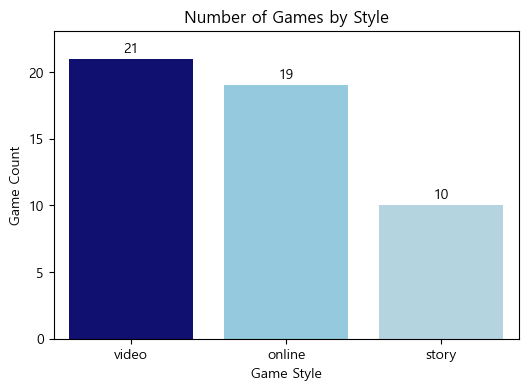

In [23]:
# 게임 스타일 별 게임 개수
game_counts = df_model.groupby('game_style')['appid'].nunique()
game_counts = game_counts.sort_values(ascending=False)  # 큰 값부터 작은 값으로 정렬
# print("Number of unique games per Game Style:")
# print(game_counts)

# value labels 시각화
plt.figure(figsize=(6,4))
bars = sns.barplot(
    x=game_counts.index,
    y=game_counts.values,
    palette=["navy", "skyblue", "lightblue"]  # 색상도 큰 순서에 맞춰
)

# 바 라벨
for bar in bars.patches:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,
        height + 0.5,           # 숫자 위로 조금 띄움
        f"{int(height)}",
        ha='center'
    )

plt.ylabel("Game Count")
plt.xlabel("Game Style")
plt.title("Number of Games by Style")
plt.ylim(0, game_counts.max() * 1.1)  # y축 상단 여유
plt.show()


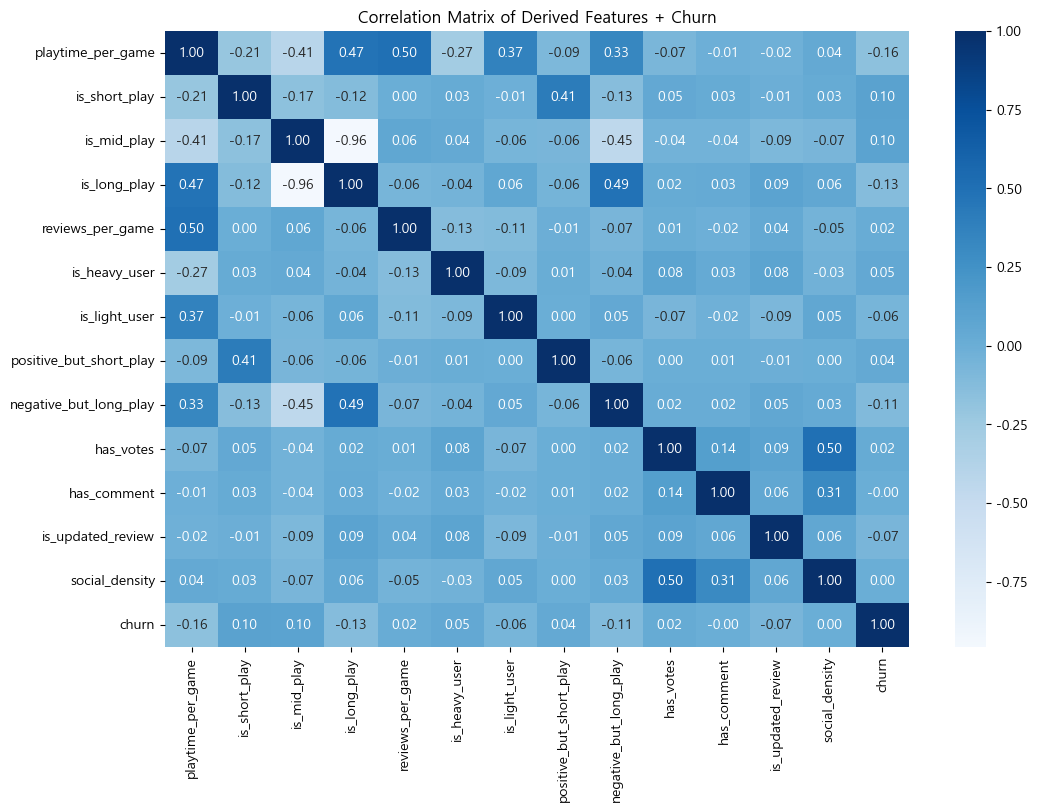

In [24]:
# 파생변수 컬럼 선택
derived_cols = [
    'playtime_per_game', 'is_short_play', 'is_mid_play', 'is_long_play',
    'reviews_per_game', 'is_heavy_user', 'is_light_user',
    'positive_but_short_play', 'negative_but_long_play',
    'has_votes', 'has_comment', 'is_updated_review', 'social_density'
]
# heatmap에 churn도 포함
derived_cols = derived_cols + ['churn']

# 상관계수 계산
corr = df_model[derived_cols].corr()

# 시각화
plt.figure(figsize=(12,8))
sns.heatmap(
    corr,
    annot=True,
    fmt=".2f",
    cmap="Blues",   # 남색 계열
    center=0
)
plt.title("Correlation Matrix of Derived Features + Churn")
plt.show()


In [25]:
df_model[derived_cols].corr()   # 파생변수와 이탈의 상관관계 수치표

,playtime_per_game,is_short_play,is_mid_play,is_long_play,reviews_per_game,is_heavy_user,is_light_user,positive_but_short_play,negative_but_long_play,has_votes,has_comment,is_updated_review,social_density,churn
playtime_per_game,1.000000,-0.212394,-0.408825,0.473144,0.500532,-0.274704,0.367424,-0.091635,0.333604,-0.072700,-0.014754,-0.018597,0.037562,-0.163035
is_short_play,-0.212394,1.000000,-0.165937,-0.123808,0.000297,0.027600,-0.013640,0.412749,-0.133707,0.045914,0.027614,-0.008654,0.026907,0.100133
is_mid_play,-0.408825,-0.165937,1.000000,-0.958005,0.059674,0.036744,-0.059378,-0.064492,-0.445760,-0.035862,-0.037900,-0.089169,-0.065174,0.097329
is_long_play,0.473144,-0.123808,-0.958005,1.000000,-0.060134,-0.045000,0.063715,-0.055125,0.487428,0.022736,0.030108,0.092244,0.057757,-0.127054
reviews_per_game,0.500532,0.000297,0.059674,-0.060134,1.000000,-0.130080,-0.109430,-0.005641,-0.068836,0.013266,-0.016785,0.038720,-0.045470,0.016397
is_heavy_user,-0.274704,0.027600,0.036744,-0.045000,-0.130080,1.000000,-0.087429,0.007369,-0.040442,0.083929,0.030605,0.084049,-0.029187,0.048576
is_light_user,0.367424,-0.013640,-0.059378,0.063715,-0.109430,-0.087429,1.000000,0.001192,0.047143,-0.069559,-0.019890,-0.085113,0.054770,-0.062861
positive_but_short_play,-0.091635,0.412749,-0.064492,-0.055125,-0.005641,0.007369,0.001192,1.000000,-0.059532,0.003588,0.005464,-0.005654,0.004184,0.036799
negative_but_long_play,0.333604,-0.133707,-0.445760,0.487428,-0.068836,-0.040442,0.047143,-0.059532,1.000000,0.016502,0.016947,0.051635,0.029256,-0.105857
has_votes,-0.072700,0.045914,-0.035862,0.022736,0.013266,0.083929,-0.069559,0.003588,0.016502,1.000000,0.138316,0.094581,0.497436,0.024715


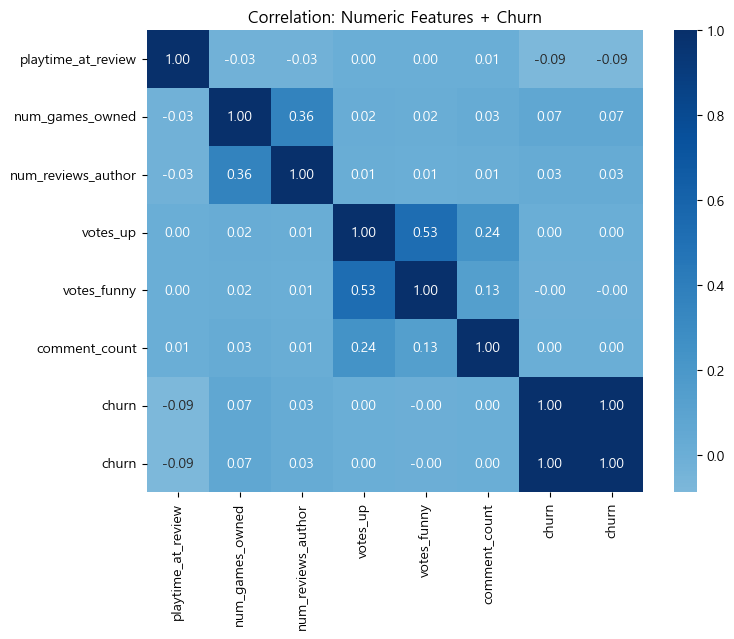

In [26]:
# 원본 수치형 컬럼 선택
numeric_cols = [
    'playtime_at_review', 
    'num_games_owned', 
    'num_reviews_author',
    'votes_up', 
    'votes_funny', 
    'comment_count'
]
# heatmap에 churn 포함
numeric_cols =  numeric_cols + ['churn']

# 상관계수 계산
corr = df_model[numeric_cols].corr()

# 숫자형 feature heatmap
plt.figure(figsize=(8,6))
corr_numeric = df_model[numeric_cols + ['churn']].corr()
sns.heatmap(corr_numeric, annot=True, fmt=".2f", cmap="Blues", center=0)
plt.title("Correlation: Numeric Features + Churn")
plt.show()



In [27]:
df_model[numeric_cols].corr()   # 숫자형 변수와 이탈 상관관계 수치표

,playtime_at_review,num_games_owned,num_reviews_author,votes_up,votes_funny,comment_count,churn
playtime_at_review,1.000000,-0.028990,-0.025153,0.001221,0.002624,0.005675,-0.088941
num_games_owned,-0.028990,1.000000,0.357889,0.024668,0.016022,0.027320,0.065056
num_reviews_author,-0.025153,0.357889,1.000000,0.012385,0.007685,0.008967,0.034341
votes_up,0.001221,0.024668,0.012385,1.000000,0.525007,0.241287,0.002123
votes_funny,0.002624,0.016022,0.007685,0.525007,1.000000,0.132761,-0.000953
comment_count,0.005675,0.027320,0.008967,0.241287,0.132761,1.000000,0.000928
churn,-0.088941,0.065056,0.034341,0.002123,-0.000953,0.000928,1.000000


Game Style Counts:
game_style
online    2458928
video     1421636
story      932657
Name: count, dtype: int64


C:\Users\Playdata\AppData\Local\Temp\ipykernel_21400\980799858.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(


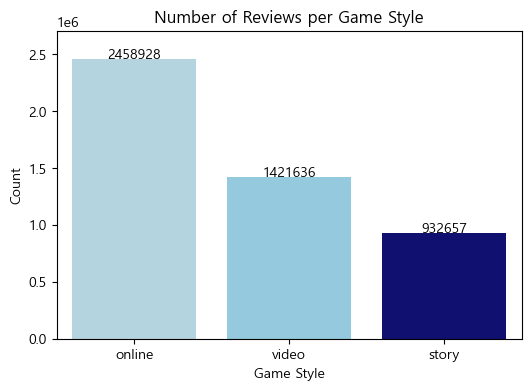

In [28]:
# Game style count
style_counts = df_model['game_style'].value_counts()
print("Game Style Counts:")
print(style_counts)

# value labels 시각화
plt.figure(figsize=(6,4))
bars = sns.barplot(
    x=style_counts.index,
    y=style_counts.values,
    palette=["lightblue", "skyblue", "navy"]
)

# 바 라벨
for bar in bars.patches:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,   # x 위치 중앙
        height + 5,                        # y 위치 약간 위
        f"{int(height)}",                  # 정수 표시
        ha='center'
    )

plt.ylim(0, style_counts.max() * 1.1)  # 최대값 + 10% 여유

plt.ylabel("Count")
plt.xlabel("Game Style")
plt.title("Number of Reviews per Game Style")
plt.show()


- is_light_user / is_heavy_user 검증
    - 기대 결과: light ↑ / heavy ↓

In [29]:
# df_model.groupby('is_light_user')['churn'].mean()
# df_model.groupby('is_heavy_user')['churn'].mean()

# sns.barplot(data=df_model, x='is_light_user', y='churn')
# plt.title('Churn Rate: Light User')
# plt.show()

# sns.barplot(data=df_model, x='is_heavy_user', y='churn')
# plt.title('Churn Rate: Heavy User')
# plt.show()

- 감정 × 행동 결합 피처 (핵심)

C:\Users\Playdata\AppData\Local\Temp\ipykernel_21400\3067907026.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bars1 = sns.barplot(
C:\Users\Playdata\AppData\Local\Temp\ipykernel_21400\3067907026.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bars2 = sns.barplot(


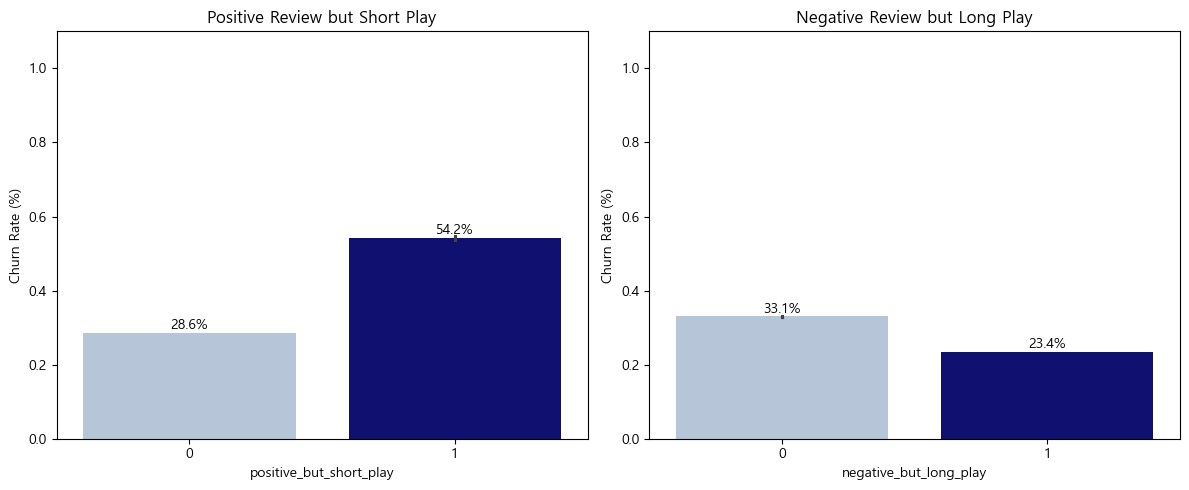

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 2, figsize=(12,5))

# --------------------------
# Positive Review but Short Play
# --------------------------
bars1 = sns.barplot(
    data=df_model,
    x='positive_but_short_play',
    y='churn',
    palette=["lightsteelblue", "navy"],  # 0=연한 파랑, 1=진한 네이비
    ax=axes[0]
)
axes[0].set_title('Positive Review but Short Play')
axes[0].set_ylabel("Churn Rate (%)")
axes[0].set_ylim(0, 1.1)

# 바 위 숫자 라벨 (%)
for bar in bars1.patches:
    height = bar.get_height()
    axes[0].text(
        bar.get_x() + bar.get_width()/2,
        height + 0.01,
        f"{height*100:.1f}%",
        ha='center'
    )

# --------------------------
# Negative Review but Long Play
# --------------------------
bars2 = sns.barplot(
    data=df_model,
    x='negative_but_long_play',
    y='churn',
    palette=["lightsteelblue", "navy"],  # 0=연한 파랑, 1=진한 네이비
    ax=axes[1]
)
axes[1].set_title('Negative Review but Long Play')
axes[1].set_ylabel("Churn Rate (%)")
axes[1].set_ylim(0, 1.1)

# 바 위 숫자 라벨 (%)
for bar in bars2.patches:
    height = bar.get_height()
    axes[1].text(
        bar.get_x() + bar.get_width()/2,
        height + 0.01,
        f"{height*100:.1f}%",
        ha='center'
    )

plt.tight_layout()
plt.show()


# 3. 데이터 전처리

In [31]:
df_model.describe()
# appid	recommendationid	steamid	num_games_owned	num_reviews_author	playtime_forever	playtime_last_two_weeks	playtime_at_review	last_played	timestamp_created	timestamp_updated	votes_up	votes_funny	weighted_vote_score	comment_count	days_after_review	churn_window_days	churn	good_review

,appid,recommendationid,steamid,num_games_owned,num_reviews_author,playtime_forever,playtime_last_two_weeks,playtime_at_review,last_played,timestamp_created,...,log_num_games_owned,log_num_reviews_author,is_heavy_user,is_light_user,positive_but_short_play,negative_but_long_play,has_votes,has_comment,is_updated_review,social_density
count,4.813221e+06,4.813221e+06,4.813221e+06,4.813221e+06,4.813221e+06,4.813221e+06,4.813221e+06,4.813221e+06,4.813221e+06,4.813221e+06,...,4.813221e+06,4.813221e+06,4.813221e+06,4.813221e+06,4.813221e+06,4.813221e+06,4.813221e+06,4.813221e+06,4.813221e+06,4.813221e+06
mean,1.637917e+06,2.034422e+08,7.656120e+16,7.224943e+01,1.093352e+01,1.398406e+04,4.346475e+02,1.067346e+04,1.761394e+09,1.756335e+09,...,2.065618e+00,1.782459e+00,3.445136e-02,1.764315e-01,4.233340e-03,4.546390e-01,2.112419e-01,3.201764e-02,9.479681e-02,6.832481e-02
std,1.156278e+06,8.342337e+06,6.190886e+08,2.492080e+02,6.318230e+01,4.066221e+04,1.151922e+03,3.810909e+04,1.145637e+07,8.849875e+06,...,2.287634e+00,1.006710e+00,1.823855e-01,3.811869e-01,6.492626e-02,4.979382e-01,4.081897e-01,1.760469e-01,2.929341e-01,2.445579e-01
min,4.400000e+02,1.848840e+08,7.656120e+16,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,5.000000e+00,0.000000e+00,1.736122e+09,...,0.000000e+00,6.931472e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,5.780800e+05,1.967549e+08,7.656120e+16,0.000000e+00,2.000000e+00,1.500000e+03,0.000000e+00,6.490000e+02,1.759989e+09,1.749423e+09,...,0.000000e+00,1.098612e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,1.551360e+06,2.059368e+08,7.656120e+16,0.000000e+00,4.000000e+00,4.166000e+03,0.000000e+00,2.093000e+03,1.765025e+09,1.759660e+09,...,0.000000e+00,1.609438e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,2.807960e+06,2.102846e+08,7.656120e+16,6.900000e+01,1.000000e+01,1.034100e+04,2.330000e+02,6.120000e+03,1.767091e+09,1.764041e+09,...,4.248495e+00,2.397895e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,3.932890e+06,2.152792e+08,7.656120e+16,3.816800e+04,1.974800e+04,2.919994e+06,3.664700e+04,2.789459e+06,1.767667e+09,1.767666e+09,...,1.054978e+01,9.890858e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,8.051128e+00


In [32]:
df_model.columns

Index(['appid', 'recommendationid', 'steamid', 'num_games_owned',
       'num_reviews_author', 'playtime_forever', 'playtime_last_two_weeks',
       'playtime_at_review', 'last_played', 'language', 'review',
       'timestamp_created', 'timestamp_updated', 'voted_up', 'votes_up',
       'votes_funny', 'weighted_vote_score', 'comment_count', 'steam_purchase',
       'received_for_free', 'written_during_early_access',
       'primarily_steam_deck', 'game_style', 'days_after_review',
       'churn_window_days', 'churn', 'good_review', 'playtime_per_game',
       'log_playtime', 'playtime_stage', 'is_short_play', 'is_mid_play',
       'is_long_play', 'reviews_per_game', 'log_num_games_owned',
       'log_num_reviews_author', 'is_heavy_user', 'is_light_user',
       'positive_but_short_play', 'negative_but_long_play', 'has_votes',
       'has_comment', 'is_updated_review', 'social_density'],
      dtype='object')

#### 수치형 변수 제외 칼럼 인코딩  

In [16]:
# df_model[['language', 'voted_up', 'steam_purchase', 'received_for_free', 'written_during_early_access', 'primarily_steam_deck', 'game_style']]

# 'language' ('english', 'koreana', ...), 'game_style' ('online','video','story') 인코딩 (True/False)
# df_model['language'].value_counts()     # 카테고리가 많아 상위 10개 미만 값들은 others로 통합.

# 상위 10개 언어 추출
top_n = 10
top_langs = df_model['language'].value_counts().head(top_n).index

# 상위 10개만 유지, 나머지는 other
df_model['language'] = df_model['language'].where(
    df_model['language'].isin(top_langs),
    'other'
)

df_model = pd.get_dummies(                  #get_dummies 는 columns 를 자동 제거
    df_model,
    columns=['language', 'game_style'],
    drop_first=True
)

In [17]:
# 생성된 컬럼 확인
print([col for col in df_model.columns if col.startswith('language_')])
print([col for col in df_model.columns if col.startswith('game_style_')]) # game_style_online은 둘다 ('game_style_story', 'game_style_video') 0 인 것

['language_english', 'language_french', 'language_german', 'language_koreana', 'language_other', 'language_polish', 'language_russian', 'language_schinese', 'language_spanish', 'language_turkish']
['game_style_story', 'game_style_video']


In [18]:
# 원핫인코딩 (True 1, False 0)

# df_model[['voted_up', 'steam_purchase', 'received_for_free', 'written_during_early_access', 'primarily_steam_deck']]
# 인코딩된 언어 칼럼들: ['language_english', 'language_french', 'language_german','language_koreana','language_other','language_polish','language_russian','language_schinese','language_spanish','language_turkish']
# 인코딩된 게임 스타일 칼럼들: ['game_style_story', 'game_style_video']

bool_cols = ['voted_up', 'steam_purchase', 'received_for_free', 'written_during_early_access', 'primarily_steam_deck',
            'language_english', 'language_french', 'language_german','language_koreana','language_other','language_polish','language_russian','language_schinese','language_spanish','language_turkish',
            'game_style_story', 'game_style_video'
            ]

for col in bool_cols:
    df_model[col] = df_model[col].astype(int)

# df_model['voted_up'].value_counts()
# df_model['language_english'].value_counts()
# df_model['game_style_story'].value_counts()

In [36]:
df_model.shape

(4813221, 54)

In [37]:
df_model.columns

Index(['appid', 'recommendationid', 'steamid', 'num_games_owned',
       'num_reviews_author', 'playtime_forever', 'playtime_last_two_weeks',
       'playtime_at_review', 'last_played', 'review', 'timestamp_created',
       'timestamp_updated', 'voted_up', 'votes_up', 'votes_funny',
       'weighted_vote_score', 'comment_count', 'steam_purchase',
       'received_for_free', 'written_during_early_access',
       'primarily_steam_deck', 'days_after_review', 'churn_window_days',
       'churn', 'good_review', 'playtime_per_game', 'log_playtime',
       'playtime_stage', 'is_short_play', 'is_mid_play', 'is_long_play',
       'reviews_per_game', 'log_num_games_owned', 'log_num_reviews_author',
       'is_heavy_user', 'is_light_user', 'positive_but_short_play',
       'negative_but_long_play', 'has_votes', 'has_comment',
       'is_updated_review', 'social_density', 'language_english',
       'language_french', 'language_german', 'language_koreana',
       'language_other', 'language_polish'

In [38]:
df_model.head(3)

,appid,recommendationid,steamid,num_games_owned,num_reviews_author,playtime_forever,playtime_last_two_weeks,playtime_at_review,last_played,review,...,language_german,language_koreana,language_other,language_polish,language_russian,language_schinese,language_spanish,language_turkish,game_style_story,game_style_video
27798,2139460,215256415,76561198092089560,0,1,1659,1659,1628.0,1767647101,"Un juego bastante completo, con diferentes esc...",...,0,0,0,0,0,0,0,0,0,0
27799,2139460,215256182,76561197995642012,0,4,370,367,339.0,1767646994,En découverte encore mais pour l'instant super...,...,0,0,0,0,0,0,0,0,0,0
27800,2139460,215249671,76561198217416651,0,32,552,552,401.0,1767648127,very nice game solo or play with team,...,0,0,1,0,0,0,0,0,0,0


### 제거해야 하는 컬럼
- id 와 이름 칼럼들 ('appid', 'recommendationid', 'steamid')
- target 변수 관련 컬럼들 ('last_played', 'timestamp_created', 'timestamp_updated', 'days_after_review','churn_window_days')
- review 시점 이후 시간 관련 칼럼들 ('playtime_last_two_weeks', 'playtime_forever')
- 결측치가 너무 많은 칼럼들 ('deck_playtime_at_review', 'developer_response', 'timestamp_dev_responded')
- 'review' 컬럼 => 'good_review' 칼럼으로 변환해서
- 파생변수 재료 컬럼들 ('playtime_at_review','num_games_owned', 'log_playtime','playtime_stage', 'num_reviews_author', 'log_num_games_owned','log_num_reviews_author', 'good_review', 'votes_up', 'votes_funny', 'comment_count', 'timestamp_created','timestamp_updated')

In [39]:
# ['appid', 'recommendationid', 'steamid', 'num_games_owned', 
# 'num_reviews_author', 'playtime_forever', 'playtime_last_two_weeks',
# 'playtime_at_review', 'last_played', 'review', 'timestamp_created',
# 'timestamp_updated', 'churn_window_days',
# 'votes_up', 'votes_funny',
# 'comment_count',
# 'days_after_review',
# 'churn', 'good_review',
# 'playtime_stage', 'log_playtime',
# 'log_num_games_owned', 'log_num_reviews_author']

In [40]:
# ['voted_up','weighted_vote_score','steam_purchase',
# 'received_for_free', 'written_during_early_access',
# 'primarily_steam_deck',

# 'playtime_per_game','is_short_play', 'is_mid_play', 'is_long_play',
# 'reviews_per_game','is_heavy_user', 'is_light_user',
# 'positive_but_short_play','negative_but_long_play', 'has_votes', 'has_comment',
# 'is_updated_review', 'social_density',

# 'language_english','language_french', 'language_german', 'language_koreana',
# 'language_other', 'language_polish', 'language_russian',
# 'language_schinese', 'language_spanish', 'language_turkish',
# 'game_style_story', 'game_style_video']

In [19]:
TARGET = "churn"

#  최종 확정한 피처
FEATURES = [
    "voted_up",
    "weighted_vote_score",
    "steam_purchase",
    "received_for_free",
    "written_during_early_access",
    "primarily_steam_deck",

    # 원핫된 language/game_style 컬럼들
    "language_english", "language_french", "language_german", "language_koreana",
    "language_other", "language_polish", "language_russian", "language_schinese",
    "language_spanish", "language_turkish",
    "game_style_story", "game_style_video",

    # 파생 피처들
    "playtime_per_game",
    "is_short_play", "is_mid_play", "is_long_play",
    "reviews_per_game",
    "is_heavy_user",'is_light_user',
    "positive_but_short_play",
    "negative_but_long_play",
    "has_votes",
    "has_comment",
    "is_updated_review",
    "social_density",
]

# 누락/오타로 없는 컬럼이 있으면 자동 제외 (코드 안깨지게)
FEATURES = [c for c in FEATURES if c in df_model.columns]

# top50 appid (리뷰 많은 순)
top_appids = (
    df_model.groupby("appid")
            .size()
            .sort_values(ascending=False)
            .head(50)
            .index.tolist()
)

print("n_features:", len(FEATURES))
print("top_appids(50) sample:", top_appids[:5])

n_features: 31
top_appids(50) sample: [3241660, 2807960, 730, 1808500, 1030300]


In [42]:
# df_model = df_model.drop(columns=['appid', 'recommendationid', 'steamid', 'num_games_owned', 
# 'num_reviews_author', 'playtime_forever', 'playtime_last_two_weeks',
# 'playtime_at_review', 'last_played', 'review', 'timestamp_created',
# 'timestamp_updated', 'churn_window_days',
# 'votes_up', 'votes_funny',
# 'comment_count',
# 'days_after_review',
# 'good_review',
# 'playtime_stage', 'log_playtime',
# 'log_num_games_owned', 'log_num_reviews_author'
# # ,'churn', 
# ])

### 데이터 분류

In [47]:
X = df_model[FEATURES]
y = df_model[TARGET]

X

,voted_up,weighted_vote_score,steam_purchase,received_for_free,written_during_early_access,primarily_steam_deck,language_english,language_french,language_german,language_koreana,...,is_long_play,reviews_per_game,is_heavy_user,is_light_user,positive_but_short_play,negative_but_long_play,has_votes,has_comment,is_updated_review,social_density
27798,1,0.50000,0,0,0,0,1,0,0,0,...,0,0.693147,0,1,0,1,0,0,0,0.000000
27799,1,0.50000,0,0,0,0,0,1,0,0,...,0,1.609438,0,0,0,0,0,0,0,0.000000
27800,1,0.50000,0,0,0,0,0,0,0,0,...,0,3.496508,0,0,0,0,0,0,0,0.000000
27801,0,0.50000,0,0,0,0,0,0,0,0,...,0,2.833213,0,0,0,0,0,0,0,0.000000
27802,1,0.50000,0,0,0,0,1,0,0,0,...,1,0.011561,0,0,0,1,0,0,0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5447568,1,0.50000,0,1,0,0,0,0,0,0,...,1,0.083881,0,0,0,1,0,0,1,0.000000
5447569,0,0.50000,0,0,0,0,0,0,0,0,...,1,0.693147,0,1,0,1,0,0,0,0.000000
5447570,1,0.50000,0,0,0,0,0,0,0,0,...,1,0.167054,0,0,0,1,0,0,1,0.000000
5447571,1,0.52381,0,0,0,0,0,0,0,0,...,0,0.287682,0,1,0,1,1,1,0,0.693147


In [73]:
# 상위 50개 게임 '전체' 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(24442, 31) (6111, 31) (24442,) (6111,)


In [ ]:
from imblearn.over_sampling import SMOTE
from collections import Counter

X_train_dict, X_test_dict = {}, {}
y_train_dict, y_test_dict = {}, {}

for appid in top_appids:
    gdf = df_model[df_model["appid"] == appid]

    if gdf[TARGET].nunique() < 2:
        print(f"appid {appid}: Not enough classes, skipping.")
        continue

    X = gdf[FEATURES]
    y = gdf[TARGET].astype(int)

    # train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=0.2,
        stratify=y,
        random_state=42
    )

    # 반드시 TRAIN 기준으로 비율 계산
    counter_train = Counter(y_train)
    minority = min(counter_train.values())
    majority = max(counter_train.values())
    ratio = minority / majority

    print(f"appid {appid} train dist: {counter_train}")

    # 너무 불균형할 때만, 1:1 말고 0.5까지만
    if ratio < 0.5 and minority >= 30:
        sm = SMOTE(
            sampling_strategy=0.5,  # 핵심
            random_state=42,
            n_jobs=-1
        )
        X_train, y_train = sm.fit_resample(X_train, y_train)
        print(f"appid {appid}: SMOTE applied → {Counter(y_train)}")

    # 저장
    X_train_dict[appid] = X_train
    X_test_dict[appid] = X_test
    y_train_dict[appid] = y_train
    y_test_dict[appid] = y_test


In [ ]:
from imblearn.over_sampling import SMOTE
from collections import Counter

# 딕셔너리 준비
X_train_dict = {}
X_test_dict = {}
y_train_dict = {}
y_test_dict = {}

for appid in top_appids:
    gdf = df_model[df_model["appid"] == appid]

    if gdf[TARGET].nunique() < 2:
        print(f"appid {appid}: Not enough classes, skipping.")
        continue

    X = gdf[FEATURES]
    y = gdf[TARGET].astype(int)

    # 클래스 비율 확인
    counter = Counter(y)
    print(f"appid {appid} class distribution: {counter}")

    # train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=0.2,
        stratify=y,
        random_state=42
    )

    # 학습용 데이터 불균형한 경우 SMOTE 적용
    smote_ratio = min(counter.values()) / max(counter.values())  # 소수/다수 비율
    if smote_ratio < 0.5:  # 임계값 예: 0.5보다 작으면 불균형
        sm = SMOTE(random_state=42)
        X_train, y_train = sm.fit_resample(X_train, y_train)
        print(f"appid {appid}: SMOTE applied. New class distribution: {Counter(y_train)}")

    # 딕셔너리에 저장   # 학습루프 안에서 다시 분리하지 않고, 사용 가능항 형식
    X_train_dict[appid] = X_train
    X_test_dict[appid] = X_test
    y_train_dict[appid] = y_train
    y_test_dict[appid] = y_test


appid 3241660 class distribution: Counter({0: 265721, 1: 74904})
appid 3241660: SMOTE applied. New class distribution: Counter({0: 212577, 1: 212577})
appid 2807960 class distribution: Counter({0: 252740, 1: 47348})
appid 2807960: SMOTE applied. New class distribution: Counter({1: 202192, 0: 202192})
appid 730 class distribution: Counter({0: 222098, 1: 50375})
appid 730: SMOTE applied. New class distribution: Counter({1: 177678, 0: 177678})
appid 1808500 class distribution: Counter({0: 205187, 1: 47090})
appid 1808500: SMOTE applied. New class distribution: Counter({0: 164149, 1: 164149})
appid 1030300 class distribution: Counter({0: 158560, 1: 80059})
appid 570 class distribution: Counter({0: 164617, 1: 39412})
appid 570: SMOTE applied. New class distribution: Counter({0: 131693, 1: 131693})
appid 578080 class distribution: Counter({0: 160299, 1: 33554})
appid 578080: SMOTE applied. New class distribution: Counter({0: 128239, 1: 128239})
appid 2246340 class distribution: Counter({0: 1

### 모델 선정, 학습, 평가

Logistic Regression (선형)

In [64]:
# #Logistic Regression
# model = LogisticRegression(
#     class_weight='balanced',                    # 불균형 보정
#     max_iter=100                                #               ->
# )
# model.fit(X_train, y_train)                     # 학습
# y_pred = model.predict(X_test)                  # 예측

# # threshold 조정 0.4 -> 오히려 성능이 안좋아짐.
# # y_prob = model.predict_proba(X_test)[:, 1]
# # y_pred = (y_prob >= 0.4).astype(int)    

# print("===== LogisticRegression Classification Report =====")
# print(classification_report(y_test, y_pred))    # 평가
# #25s

In [63]:
# #confusion_matrix; 혼동행렬지표

# cm = confusion_matrix(y_test, y_pred)
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0,1], yticklabels=[0,1])
# plt.xlabel('Predicted')
# plt.ylabel('Actual')
# plt.show()

RandomForest (비선형)

In [65]:
# # RandomForest
# rf = RandomForestClassifier(
#     class_weight='balanced',                    # 불균형 보정
#     n_estimators=200,                           # 트리수 -> 안정성       ^
#     max_depth=10,                               # 과적합 방지
#     min_samples_leaf=5,                         # 노이즈 억제            +
#     random_state=42                             #
# )
# rf.fit(X_train, y_train)                        #학습

# y_pred_rf = rf.predict(X_test)                  #예측

# # threshold 조정
# # y_prob = rf.predict_proba(X_test)[:, 1]
# # y_pred_rf = (y_prob >= 0.4).astype(int)    

# print("===== RandomForest Classification Report =====")
# print(classification_report(y_test, y_pred_rf)) # 평가
# #11m

In [66]:
# #confusion_matrix; 혼동행렬지표
# cm = confusion_matrix(y_test, y_pred_rf)
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0,1], yticklabels=[0,1])
# plt.xlabel('Predicted')
# plt.ylabel('Actual')
# plt.show()

XGBoost (비선형)

In [67]:
# # XGBoost
# xgb = XGBClassifier(
#     n_estimators=200,                           #
#     max_depth=10,                               #
#     # scale_pos_weight=(y_train==0).sum() / (y_train==1).sum(),  # 불균형 보정
#     # use_label_encoder=False,                  #
#     #learning_rate=0.05,
#     #subsample=0.8,
#     #colsample_bytree=0.8,
#     # min_child_weight =10,
#     eval_metric='logloss',                      #
#     random_state=42                             #
# )
# xgb.fit(X_train, y_train)                       #학습

# y_pred_xgb = xgb.predict(X_test)                #예측

# # threshold 조정
# # y_prob = xgb.predict_proba(X_test)[:, 1]
# # y_pred_xgb = (y_prob >= 0.4).astype(int)    

# print("===== XGBoost Classification Report =====")
# print(classification_report(y_test, y_pred_xgb)) # 평가
# #3\21s

In [68]:
# #confusion_matrix; 혼동행렬지표
# cm = confusion_matrix(y_test, y_pred_xgb)
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0,1], yticklabels=[0,1])
# plt.xlabel('Predicted')
# plt.ylabel('Actual')
# plt.show()

=> 상위 50개 게임 "전체" Best Model: XGBoost  

❝ 세 모델을 비교한 결과,  
XGBoost는 precision과 recall의 균형이 가장 우수하며  
특히 타겟 클래스(1)에 대해 높은 f1-score를 기록하였다.  
또한 전체 데이터 기준 weighted f1-score와 accuracy가 가장 높아  
전반적인 일반화 성능에서도 우수하다고 판단하여  
최종 모델로 선정하였다. ❞  

In [61]:
# # 결과 저장용
# results_list = []

# 모델 정의
models = {
    "Logistic": Pipeline([
        ("scaler", StandardScaler()),  # LR은 스케일링 필요
        ("clf", LogisticRegression(max_iter=2000, class_weight="balanced", random_state=42))
    ]),
    "RandomForest": RandomForestClassifier(
        n_estimators=300,
        max_depth=None,
        class_weight="balanced",
        random_state=42
        # , n_jobs=-1 #?
    ),
    "XGBoost": XGBClassifier(
        n_estimators=300,
        learning_rate=0.05,
        use_label_encoder=False,
        eval_metric="logloss",
        random_state=42
    )
}

# for appid in top_appids:
#     if appid not in X_train_dict:
#         continue  # churn 클래스 부족으로 skip된 게임

#     # 딕셔너리에서 불러오기
#     X_train = X_train_dict[appid]
#     X_test = X_test_dict[appid]
#     y_train = y_train_dict[appid]
#     y_test = y_test_dict[appid]

#     print(f"\n--- appid {appid} ---")
#     for name, model in models.items():
#         # 학습
#         model.fit(X_train, y_train)

#         # 예측
#         y_pred = model.predict(X_test)
#         y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

#         # classification report
#         print(f"\n{name} Classification Report:")
#         print(classification_report(y_test, y_pred, digits=3))

#         # confusion matrix
#         cm = confusion_matrix(y_test, y_pred)
#         print("Confusion Matrix:\n", cm)

#         # 결과 기록
#         results_list.append({
#             "appid": appid,
#             "model": name,
#             "y_true": y_test,
#             "y_pred": y_pred,
#             "y_proba": y_proba
#         })


결과 출력 저장 json 파일로 생성까지!

In [35]:
# import json
# from sklearn.metrics import classification_report, confusion_matrix

# results_list = []

# for appid in top_appids:
#     if appid not in X_train_dict:
#         continue  # churn 클래스 부족으로 skip된 게임

#     X_train = X_train_dict[appid]
#     X_test = X_test_dict[appid]
#     y_train = y_train_dict[appid]
#     y_test = y_test_dict[appid]

#     for name, model in models.items():  #     for name, model in tqdm(models.items(), desc=f"Training models for appid {appid}", leave=False):
#         # 학습
#         model.fit(X_train, y_train)

#         # 예측
#         y_pred = model.predict(X_test)
#         y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

#         # classification report dict 형태로 저장
#         clf_report = classification_report(y_test, y_pred, output_dict=True)
#         cm = confusion_matrix(y_test, y_pred).tolist()  # 2차원 배열 → list로 변환

#         # 결과 기록
#         results_list.append({
#             "appid": appid,
#             "model": name,
#             "y_true": y_test.tolist(),
#             "y_pred": y_pred.tolist(),
#             "y_proba": y_proba.tolist() if y_proba is not None else None,
#             "classification_report": clf_report,
#             "confusion_matrix": cm
#         })

# # JSON 파일로 저장
# with open("game_models_results.json", "w") as f:
#     json.dump(results_list, f, indent=4)

# # 42m

In [36]:
# # 학습 후 json으로 기록된 결과 불러오기
# with open("game_models_results.json", "r") as f:
#     loaded_results = json.load(f)

### 하이퍼파라미터 튜닝, 재학습

## GridSearchCV

In [49]:
# # GridSearchCV로 최적의 하이퍼파라미터를 찾는다.
# from sklearn.model_selection import GridSearchCV

# parameters = {
#     "max_depth":[2,3,5,10],         # 트리 최대 깊이
#     'min_samples_split':[2,3,5],    # 노드 분할시 최소 샘플 수 
#     'min_samples_leaf':[1,5,8]      # 리프 노드에 반드시 남아야 하는 최소 샘플 수
# }

# grid_dclf = GridSearchCV(dt_clf, param_grid=parameters, scoring='accuracy', cv=5)
# grid_dclf.fit(X_train, y_train)

# print('GridSearchCV의 최적의 하이퍼 파라미터', grid_dclf.best_params_)
# print('GridSearchCV의 최적의 정확도', grid_dclf.best_score_)

# best_dclf = grid_dclf.best_estimator_       #최적의 모델 저장

# #최적의 하이퍼 파라미터로 학습된 Estimator로 예측 및 평가 수행
# dpredictions = best_dclf.predict(X_test)
# accuracy = accuracy_score(y_test, dpredictions)
# print("DecisionTreeClassifier의 정확도: {accuracy:.4f}")

## Optuna

In [ ]:
# "import optuna
# from sklearn.model_selection import StratifiedKFold, cross_val_score    # KFold 사용, CV 점수 계산
# from sklearn.tree import DecisionTreeClassifier     # 하이퍼파라미터 튜닝할 모델 (의사결정나무)
# from sklearn.metrics import accuracy_score  # 정확도

# # optuna가 한번 trial(시도) 할 때마다 하이퍼파라미터를 제안하는 범위를 지정한다.
# # trial.suggest_ : optuna가 값을 뽑는 함수 (GridSearchCV에서 '그리드' 역할)
# def objective(trial):
#     params = {
#         'max_depth': trial.suggest_int('max_depth',2,10),                       # 트리 깊이: 2~10 중 선택
#         'min_samples_split': trial.suggest_int('min_samples_split',2,10),       # 분기 최소 샘플 수: 2~10 중 선택
#         'min_samples_leaf': trial.suggest_int('min_samples_leaf',1,10),         # 리프 최소 샘플 수: 1~10 중 선택
#         'random_state': 11                                                      # 재현성(시드 고정)
#     }

#     model = DecisionTreeClassifier(**params)        # 모델 생성 (** (unpacking) : 딕셔너리 key=value 쌍을 펼쳐서 넣는다.)
#     # 교차검증 설정 (StratifiedKFold: fold 마다 클래스 비율을 유지, 불균형 데이터에 강하다.)
#     cv = StratifiedKFold(
#         n_splits=5,         # 5등분
#         shuffle=True,       # 데이터 랜덤으로 섞음
#         random_state=11     # 섞는 방식은 고정 (재현성)
#     )

#     # 학습 폴드로 fit, 검증 폴드로 predict, scoring 기준으로 점수 계산, 5번 반복 후 점수 배열 반환
#     scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy')

#     return scores.mean()        # 평균 정확도를 반환. => Optuna 가 최대화할 값 반환 (평균 정확도가 높아지는 방향으로 파라미터를 잡는다.)

# # Optuna 스터디 생성 (direction='maximize': objective 가 반환하는 값(정확도)를 최대화하도록 탐색)
# study = optuna.create_study(direction='maximize')

# # 최적화 수행
# study.optimize(
#     objective,      #함수(파라미터를 업데이트하는데 참고하는 함수)
#     n_trials=50     #파라미터 조합 시도수
# )

# # 탐색 결과 출력
# print('Optuna 최적 하이퍼파라미터:', study.best_params)
# print(f'Optuna 교차검증 최고 정확도: {study.best_value:.4f}')

# #최적 파라미터 적용 (best_params는 딕셔너리 형태이기 때문에 unpacking)
# best_optuna_df = DecisionTreeClassifier(**study.best_params, random_state=11)  
# best_optuna_df.fit(X_train, y_train)

# #평가
# optuna_pred = best_optuna_df.predict(X_test)        # 테스트 데이터 예측
# optuna_acc = accuracy_score(y_test, optuna_pred)    # 테스트 정확도 계산
# print(f'테스트셋으로 평가한 Optuna 튜닝 DecisionTreeClassifier 정확도: {optuna_acc:.4f}')"

#### 재학습

#### 다른 모델 비교 안한 이유

❝ 선형 모델(Logistic Regression)로 기본적인 churn 패턴과 변수 영향을 해석하고,  
트리 기반 비선형 모델(RandomForest, XGBoost)을 통해 변수 간 복합적인 상호작용을 학습하여 예측 성능을 개선했습니다.  
이외의 모델들은 성능 대비 해석성과 효율 등을 고려하여 제외했습니다. ❞  

*파라미터 튜닝 할 때 참고

- randomforest 수정

n_estimators: 클수록 안정

max_depth: 과적합 방지

min_samples_leaf: 노이즈 억제

- xgb 수정

성능 불안 → learning_rate ↓, n_estimators ↑

과적합 → max_depth ↓, subsample ↓


## 학습루프 (상위 50개 게임 각각)

각 게임별 50개 모델 학습 후, 세 모델(Logistic, RandomForest, XGBoost) 중 test F1 기준으로 최고 모델만 선택

In [34]:

# # ==========================
# # 1. 설정
# # ==========================
# os.makedirs("model_per_game", exist_ok=True)
# RANDOM_STATE = 42
# TEST_SIZE = 0.2
# TARGET = 'churn'
# FEATURES = X.columns.tolist()

# # ==========================
# # 2. 모델 정의
# # ==========================
# models = {
#     "Logistic": Pipeline([
#         ("scaler", StandardScaler()),
#         ("clf", LogisticRegression(max_iter=2000, class_weight="balanced", random_state=RANDOM_STATE))
#     ]),
#     "RandomForest": RandomForestClassifier(
#         n_estimators=300,
#         max_depth=None,
#         random_state=RANDOM_STATE,
#         class_weight="balanced",
#         n_jobs=-1
#     ),
#     "XGBoost": xgb.XGBClassifier(
#         n_estimators=300,
#         max_depth=6,
#         learning_rate=0.05,
#         use_label_encoder=False,
#         eval_metric="logloss",
#         random_state=RANDOM_STATE
#     )
# }

# # 상위 50개 게임
# top_appids = df_model['appid'].value_counts().head(50).index

# # 결과 저장용
# results = []

# # ==========================
# # 3. 게임별 모델 학습
# # ==========================
# for appid in tqdm(top_appids, desc="Top 50 Games"):
#     gdf = df_model[df_model['appid'] == appid]
    
#     # 클래스가 하나만 있으면 학습 불가
#     if gdf[TARGET].nunique() < 2:
#         continue

#     X_game = gdf[FEATURES]
#     y_game = gdf[TARGET]

#     X_train, X_test, y_train, y_test = train_test_split(
#         X_game, y_game, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y_game
#     )

#     game_results = []

#     for name, model in models.items():
#         model.fit(X_train, y_train)
#         y_pred = model.predict(X_test)
#         y_proba = model.predict_proba(X_test)[:, 1]

#         metrics = {
#             "appid": appid,
#             "model": name,
#             "test_acc": accuracy_score(y_test, y_pred),
#             "test_f1": f1_score(y_test, y_pred),
#             "test_precision": precision_score(y_test, y_pred),
#             "test_recall": recall_score(y_test, y_pred),
#             "test_roc_auc": roc_auc_score(y_test, y_proba)
#         }

#         game_results.append({**metrics, "model_obj": model})

#     # ==========================
#     # 4. 각 게임별 최고 모델 선택 (test F1 기준)
#     # ==========================
#     best_game_model = max(game_results, key=lambda x: x["test_f1"])
#     results.append(best_game_model)

#     # 모델 저장
#     joblib.dump(best_game_model["model_obj"], f"model_per_game/model_{appid}_{best_game_model['model']}.pkl")

# # ==========================
# # 5. 결과 DataFrame
# # ==========================
# results_df = pd.DataFrame(results).drop(columns=['model_obj'])
# results_df = results_df.sort_values("test_f1", ascending=False).reset_index(drop=True)
# display(results_df.head(20))


테이블 형식 + classification_report 수치 포함 버전으로

In [33]:

# summary = []

# for appid in top_appids:
#     gdf = df_model[df_model['appid'] == appid]
#     if gdf[TARGET].nunique() < 2:
#         continue
    
#     X_game = gdf[FEATURES]
#     y_game = gdf[TARGET]
    
#     X_train, X_test, y_train, y_test = train_test_split(
#         X_game, y_game, test_size=0.2, random_state=RANDOM_STATE, stratify=y_game
#     )
    
#     # 최고 모델 선택 (test F1 기준)
#     game_results = []
#     for name, model in models.items():
#         model.fit(X_train, y_train)
#         y_pred = model.predict(X_test)
#         y_proba = model.predict_proba(X_test)[:, 1]
#         f1 = f1_score(y_test, y_pred)
#         game_results.append({"model": name, "f1": f1, "model_obj": model, "y_pred": y_pred, "y_true": y_test})
    
#     best = max(game_results, key=lambda x: x["f1"])
    
#     # classification report
#     cr = classification_report(best["y_true"], best["y_pred"], output_dict=True)
    
#     # summary 테이블용
#     summary.append({
#         "appid": appid,
#         "best_model": best["model"],
#         "f1_0": cr["0"]["f1-score"],
#         "f1_1": cr["1"]["f1-score"],
#         "accuracy": cr["accuracy"]
#     })

# summary_df = pd.DataFrame(summary).sort_values("accuracy", ascending=False)
# display(summary_df)


### INSIGHT Page

### 🎮 STEAM 게임 이탈(Churn) 인사이트 대시보드  
플레이어 행동과 리뷰 패턴을 통한 조기 이탈 예측

#### 전체 이탈 현황 (Overall Churn Overview)

"STEAM 상위 50개 게임의 리뷰 데이터를 분석한 결과,
긍정적인 리뷰를 남긴 사용자 중에서도 상당수가 이후 게임을 이탈하는 것으로 나타났습니다."

즉, 리뷰 평점이나 추천 여부만으로는
플레이어의 실제 잔존 여부를 정확히 판단하기 어렵습니다.

💡 핵심 포인트

이탈은 ‘말(리뷰)’보다 ‘행동(플레이 패턴)’에서 더 잘 드러납니다.

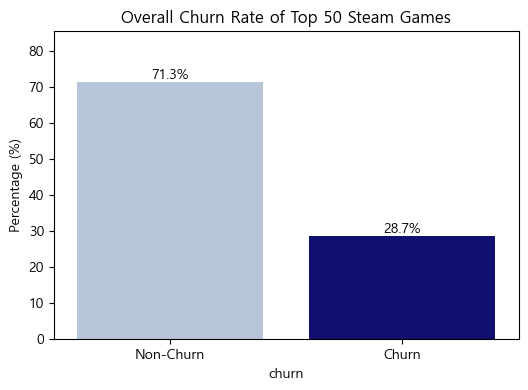

C:\Users\Playdata\AppData\Local\Temp\ipykernel_15964\1809349176.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(


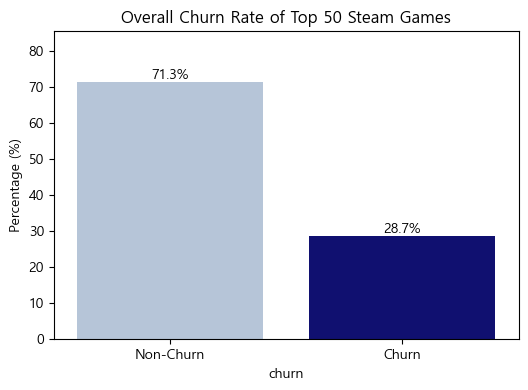

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

churn_ratio = df_model['churn'].value_counts(normalize=True) * 100

plt.figure(figsize=(6,4))
bars = sns.barplot(
    x=churn_ratio.index,
    y=churn_ratio.values,
    palette=["lightsteelblue", "navy"]
)

plt.xticks([0,1], ['Non-Churn', 'Churn'])
plt.ylabel("Percentage (%)")
plt.title("Overall Churn Rate of Top 50 Steam Games")

for bar in bars.patches:
    h = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,
        h + 1,
        f"{h:.1f}%",
        ha="center"
    )

plt.ylim(0, churn_ratio.max() * 1.2)
plt.show()


#### 게임 스타일별 이탈 특성

"게임 스타일(Story / Video / Online)에 따라
이탈 패턴과 잔존 구조가 뚜렷하게 다르게 나타났습니다."

- 스토리형 게임: 짧고 명확한 소비 구조

- 온라인/반복형 게임: 장기 플레이 기반 구조

같은 이탈이라도 게임 장르에 따라 의미가 달라집니다.

💡 핵심 포인트

이탈 분석은 게임 스타일을 고려하지 않으면 왜곡될 수 있습니다.

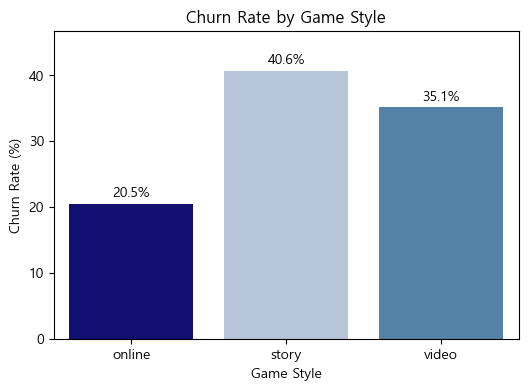

C:\Users\Playdata\AppData\Local\Temp\ipykernel_15964\1175175622.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


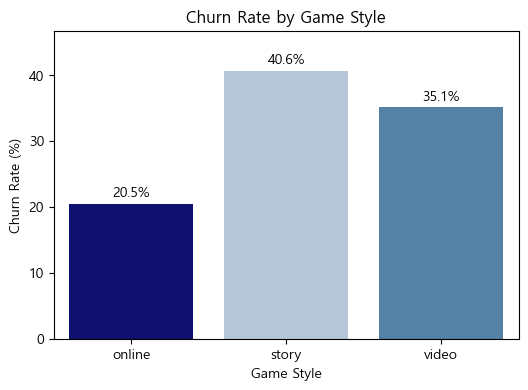

In [29]:
style_churn = (
    df_model.groupby('game_style')['churn']
            .mean()
            .mul(100)
            .reset_index()
)

plt.figure(figsize=(6,4))

ax = sns.barplot(
    data=style_churn,
    x='game_style',
    y='churn',
    palette=["navy", "lightsteelblue", "steelblue"]  # 3색
)

plt.ylabel("Churn Rate (%)")
plt.xlabel("Game Style")
plt.title("Churn Rate by Game Style")

# 바 위에 퍼센트 라벨 추가
for container in ax.containers:
    ax.bar_label(
        container,
        fmt="%.1f%%",
        padding=3,
        fontsize=10
    )

plt.ylim(0, style_churn['churn'].max() * 1.15)  # 라벨 잘리기 방지
plt.show()


#### 리뷰 감정 × 플레이 행동 결합 (핵심 인사이트)
"가장 강력한 이탈 신호는
리뷰 감정과 실제 플레이 행동이 어긋날 때 나타났습니다."

특히 다음 두 패턴이 매우 중요합니다.

- 긍정 리뷰 + 짧은 플레이 시간
→ “재밌다고 했지만 금방 떠난 유저”

- 부정 리뷰 + 긴 플레이 시간
→ “불평하지만 계속 플레이하는 유저”

이러한 패턴은 기존 지표로는 포착하기 어려운
숨겨진 이탈 위험과 잔존 가능성을 보여줍니다.

💡 핵심 포인트

‘말과 행동의 불일치’가 조기 이탈을 가장 잘 설명합니다.

C:\Users\Playdata\AppData\Local\Temp\ipykernel_15964\267561381.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(


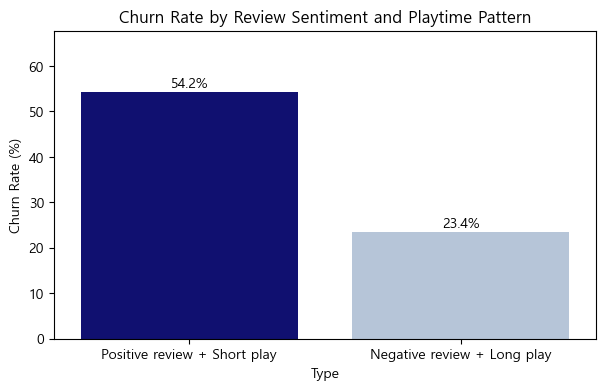

In [30]:
import pandas as pd

data = pd.DataFrame({
    "Type": ["Positive review + Short play", "Negative review + Long play"],
    "Churn Rate (%)": [
        df_model.loc[df_model['positive_but_short_play'] == 1, 'churn'].mean() * 100,
        df_model.loc[df_model['negative_but_long_play'] == 1, 'churn'].mean() * 100
    ]
})

plt.figure(figsize=(7,4))
bars = sns.barplot(
    data=data,
    x="Type",
    y="Churn Rate (%)",
    palette=["navy", "lightsteelblue"]
)

for bar in bars.patches:
    h = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,
        h + 1,
        f"{h:.1f}%",
        ha="center"
    )

plt.title("Churn Rate by Review Sentiment and Playtime Pattern")
plt.ylim(0, data["Churn Rate (%)"].max() * 1.25)
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 2, figsize=(12,5))

# --------------------------
# Positive Review but Short Play
# --------------------------
bars1 = sns.barplot(
    data=df_model,
    x='positive_but_short_play',
    y='churn',
    palette=["lightsteelblue", "navy"],  # 0=연한 파랑, 1=진한 네이비
    ax=axes[0]
)
axes[0].set_title('Positive Review but Short Play')
axes[0].set_ylabel("Churn Rate (%)")
axes[0].set_ylim(0, 1.1)

# 바 위 숫자 라벨 (%)
for bar in bars1.patches:
    height = bar.get_height()
    axes[0].text(
        bar.get_x() + bar.get_width()/2,
        height + 0.01,
        f"{height*100:.1f}%",
        ha='center'
    )

# --------------------------
# Negative Review but Long Play
# --------------------------
bars2 = sns.barplot(
    data=df_model,
    x='negative_but_long_play',
    y='churn',
    palette=["lightsteelblue", "navy"],  # 0=연한 파랑, 1=진한 네이비
    ax=axes[1]
)
axes[1].set_title('Negative Review but Long Play')
axes[1].set_ylabel("Churn Rate (%)")
axes[1].set_ylim(0, 1.1)

# 바 위 숫자 라벨 (%)
for bar in bars2.patches:
    height = bar.get_height()
    axes[1].text(
        bar.get_x() + bar.get_width()/2,
        height + 0.01,
        f"{height*100:.1f}%",
        ha='center'
    )

plt.tight_layout()
plt.show()


#### 소셜 활동과 이탈의 관계
"투표(vote), 댓글(comment), 리뷰 수정(update) 등
소셜 상호작용이 있는 유저는 이탈 확률이 현저히 낮았습니다."

이는 단순한 플레이를 넘어
게임 커뮤니티에 정서적으로 연결되어 있음을 의미합니다.

💡 핵심 포인트

커뮤니티 참여는 강력한 잔존 신호입니다.

C:\Users\Playdata\AppData\Local\Temp\ipykernel_15964\1595807020.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


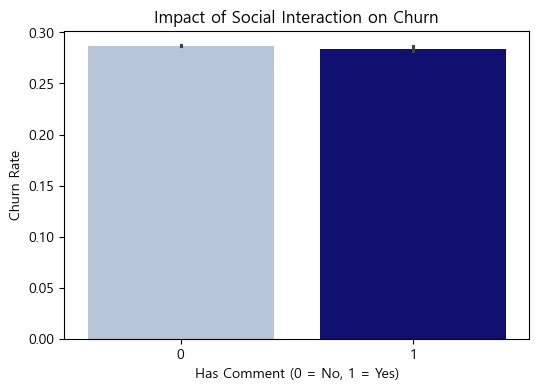

In [31]:
social_cols = ['has_votes', 'has_comment', 'is_updated_review']

social_churn = (
    df_model.groupby(social_cols)['churn']
            .mean()
            .reset_index()
)

plt.figure(figsize=(6,4))
sns.barplot(
    data=df_model,
    x='has_comment',
    y='churn',
    palette=["lightsteelblue", "navy"]
)

plt.ylabel("Churn Rate")
plt.xlabel("Has Comment (0 = No, 1 = Yes)")
plt.title("Impact of Social Interaction on Churn")
plt.show()


#### 모델이 중요하게 본 변수들
"이탈 예측 모델은 단순 평점보다
행동 기반 파생 변수에 더 큰 가중치를 두었습니다."

주요 특징:

게임당 플레이 밀도

리뷰 활동 강도

감정 × 행동 결합 변수

소셜 상호작용 지표

이 변수들은 리뷰 점수보다
이탈 여부를 훨씬 잘 설명했습니다.

💡 핵심 포인트

이탈 예측에서 중요한 것은 평가가 아니라 행동입니다.

In [ ]:
# import pandas as pd
# import matplotlib.pyplot as plt

# # 예시: 특정 appid의 학습된 LightGBM 모델
# model = best_model   # 저장된 모델 중 하나
# features = FEATURES

# # 중요도 추출
# imp = pd.Series(
#     model.feature_importances_,
#     index=features
# ).sort_values()

# # 상위 15개만 시각화
# imp.tail(15).plot(
#     kind='barh',
#     figsize=(8,6),
#     color='navy'
# )

# plt.title("Top Feature Importance (LightGBM)")
# plt.xlabel("Importance")
# plt.tight_layout()
# plt.show()


In [ ]:
# import numpy as np

# all_importances = []

# for row in result_list:  # 모델 저장 리스트
#     if row["model"] == "LightGBM":
#         imp = row["model_obj"].feature_importances_
#         all_importances.append(imp)

# mean_imp = np.mean(all_importances, axis=0)

# imp_df = pd.Series(mean_imp, index=FEATURES).sort_values().tail(15)

# plt.figure(figsize=(8,6))
# imp_df.plot(kind="barh", color="steelblue")
# plt.title("Average Feature Importance Across Games")
# plt.xlabel("Importance")
# plt.tight_layout()
# plt.show()


#### 게임별 개별 이탈 예측 모델
"본 프로젝트에서는 하나의 통합 모델이 아니라  
게임(appid)별 개별 이탈 예측 모델을 학습했습니다."

이 방식의 장점:

게임마다 다른 이탈 기준 반영

플레이 패턴 차이 자연스럽게 반영

과적합 감소 및 해석력 향상

💡 핵심 포인트

이탈의 정의는 게임마다 다르며, 모델도 달라야 합니다.

In [ ]:
# import seaborn as sns
# import matplotlib.pyplot as plt

# plt.figure(figsize=(8,4))
# sns.histplot(
#     data=results_df,
#     x="test_f1",
#     bins=20,
#     color="navy"
# )

# plt.title("Distribution of Test F1-score Across Games")
# plt.xlabel("Test F1-score")
# plt.ylabel("Number of Games")
# plt.tight_layout()
# plt.show()


In [ ]:
# plt.figure(figsize=(7,5))
# sns.scatterplot(
#     data=results_df,
#     x="churn_rate",
#     y="test_f1",
#     hue="model",
#     palette="Blues"
# )

# plt.title("Churn Rate vs Prediction Performance")
# plt.xlabel("Churn Rate")
# plt.ylabel("Test F1-score")
# plt.legend(title="Model")
# plt.tight_layout()
# plt.show()


이 서비스는  
플레이어가 무엇을 말했는지보다, 어떻게 행동했는지를 분석하여  
이탈을 조기에 탐지합니다.  

리뷰, 플레이 데이터, 소셜 신호를 결합해  
실제 행동 기반의 이탈 인사이트를 제공합니다.